# Qubit Tune-up with SHF Instruments

In this notebook we demonstrate qubit tuneup with the LabOne Q software, implemented as a sequence of experiments. 

Before starting the experiments, we define a set of initial qubit parameters, as might be known from fabrication. 

These parameters can then be used to update the baseline calibration used in the experiments.

## 0. General Imports and Definitions
### 0.1 Python Imports 

In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np

### 0.2 Function Definitions

In [2]:
# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"res_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        stop=stop_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        count=num_points,
    )

# function that returns the calibration of the readout line oscillator for spectroscopy
def res_spec_calib(frequency_sweep, amplitude_sweep=None):
    exp_calibration = Calibration()
    # sets the oscillator of the experimental measure signal
    exp_calibration["measure"] = SignalCalibration(
        # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
        oscillator=Oscillator(
            "readout_osc",
            frequency=frequency_sweep,
            modulation_type=ModulationType.HARDWARE,
        ),
        amplitude=amplitude_sweep,
    )
    return exp_calibration


# signal maps for the qubit readout only
def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

# create gaussian square pulse for readout
def create_readout_pulse(
    qubit, sigma=0.2
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined['readout_len'],
        amplitude=qubit.parameters.user_defined['readout_amp'],
        width=qubit.parameters.user_defined['readout_len'] * 0.9,
        sigma=sigma,
    )
    return readout_pulse

# qubit spectroscopy freq sweep
def create_drive_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"drive_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        stop=stop_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        count=num_points,
    )

# define square pulse for qubit spec
def create_drive_spec_pulse(qubit, amp = 0.95):
    pulse = pulse_library.const(
        uid=f"drive_spec_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=amp, #max power to start
    )
    return pulse

# signal map for qubit drive and readout
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

#define gaussian pulse for qubit drive
def create_rabi_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1,
    )

# define qubit drive rabi sweep
def create_rabi_amp_sweep(qubit, amp_num, uid="rabi_amp"):
    amp_min = 0.1
    amp_max = min([qubit.parameters.user_defined['amplitude_pi'] * 2.2, 1.0])
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

# define delay time sweep for Ramsey, T1, echo
def create_delay_sweep(
    start=0, stop=50e-6, count=100, axis_name="Time [s]"
):
    time_sweep = LinearSweepParameter(
        uid="time_sweep_param", start=start, stop=stop, count=count, axis_name=axis_name
    )
    return time_sweep

# define ramsey drive pulse
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'] / 2,
    )

# define T1 drive pulse
def create_T1_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

def create_pi_2_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_2_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']/2,
    )

def create_pi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

## 1. Define the Instrument Setup and Required Experimental Parameters
### 1.1 Create device setup

Create the device setup from the descriptor, and apply some convenient mapping to instruments and logical signals.

In [3]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12237
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/2/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

In [4]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

### 1.2 Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings

May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [5]:
q0 = Transmon.from_logical_signal_group(
    "q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.15e9,     #Drive frequency for qubit ge transition
        resonance_frequency_ef=2.95e9,     #Drive frequency for qubit ef transtion
        drive_lo_frequency=6.5e9,          #Center frequency for qubit drive, needs to be within 500 MHz of both ge and ef frequencies
        readout_resonator_frequency=6.040e9, #Readout frequency for readout resonator
        readout_lo_frequency=6.5e9,        #Center frequency for readout line, shared node, all qubits need to have the same value
        readout_integration_delay=60e-9,       #Propogation delay for readout aqcuire line, relative to default 212 ns, shared node, all qubits need to have the same value
        drive_range = 10,                  #Output range for qubit drive in dBm
        readout_range_out = -0,             #Output range for readout resonator in dBm, shared node, all qubits need to have the same value
        readout_range_in = -15,              #Input range for readout resonator in dBm, shared node, all qubits need to have the same value
        
        user_defined={                     #Pulse Parameters to be included as user_defined
            "amplitude_pi": 0.99,           #Amplitude of Pi pulse, linear gain from 0 to 1 of drive_range
            "pulse_length": 50e-9,         #Length of drive/Pi pulse
            "readout_len": 2e-6,           #Length of readout pulse
            "readout_amp": 0.98,           #Amplitude of readout pulse, linear gain from 0 to 1 of readout_range_out, starts at 1 for spectroscopy
            "reset_length": 5e-6,          #Relaxation time to return to ground state
        },
    ),
)

q1 = Transmon.from_logical_signal_group(
    "q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=6.25e9,
        resonance_frequency_ef=5.95e9,
        drive_lo_frequency=7.1e9,
        readout_resonator_frequency=7.4e9,
        readout_lo_frequency=q0.parameters.readout_lo_frequency, #Shared node, needs to match q0 center frequency
        readout_integration_delay=q0.parameters.readout_integration_delay, #Shared node, needs to match q0
        drive_range = 10,
        readout_range_out = q0.parameters.readout_range_out, #Shared node, needs to match q0
        readout_range_in = q0.parameters.readout_range_in, #Shared node, needs to match q0
        user_defined={
            "amplitude_pi": 0.6,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.98,
            "reset_length": 5e-6,
        },
    ),
)

In [6]:
q0.parameters.resonance_frequency_ge=1300000000.0
q0.parameters.resonance_frequency_ef=2950000000.0
q0.parameters.drive_lo_frequency=1000000000.0
q0.parameters.readout_resonator_frequency=6819000000.0
q0.parameters.readout_lo_frequency=6500000000.0
q0.parameters.readout_integration_delay=6e-08
q0.parameters.drive_range=-15
q0.parameters.readout_range_out=-30
q0.parameters.readout_range_in=-15
q0.parameters.flux_offset_voltage=0
q0.parameters.user_defined={
'amplitude_pi': 0.39,
'pulse_length': 2e-06,
'readout_len': 2e-06,
'readout_amp': 0.3,
'reset_length': 5e-07,}

q1.parameters.resonance_frequency_ge=977580000.0
q1.parameters.resonance_frequency_ef=5950000000.0
q1.parameters.drive_lo_frequency=1400000000.0
q1.parameters.readout_resonator_frequency=6883500000.0
q1.parameters.readout_lo_frequency=6500000000.0
q1.parameters.readout_integration_delay=6e-08
q1.parameters.drive_range=-10
q1.parameters.readout_range_out=-15
q1.parameters.readout_range_in=-15
q1.parameters.flux_offset_voltage=0
q1.parameters.user_defined={
'amplitude_pi': 0.99,
'pulse_length': 1e-06,
'readout_len': 2e-06,
'readout_amp': 0.03,
'reset_length': 5e-07,}

In [7]:
#Finish calibrating SHFQC with qubit parameters
qubits = [q0, q1]
for qubit in qubits:
    device_setup.set_calibration(qubit.calibration())

#Choose which qubit will be measured
measure_q = q0

### 2.2 Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments

In [8]:
# perform experiments in emulation mode or on hardware - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.08.02 15:52:20.837] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\laboneq_output\log
[2024.08.02 15:52:20.841] INFO    VERSION: laboneq 2.32.0
[2024.08.02 15:52:20.844] INFO    Connecting to data server at localhost:8004
[2024.08.02 15:52:20.908] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.08.02 15:52:20.930] WARNING SHFQC/QA:dev12237: Include the device options 'SHFQC/PLUS/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.08.02 15:52:21.905] INFO    Configuring the device setup
[2024.08.02 15:52:22.018] INFO    The device setup is configured


## 3. Qubit Tuneup - Experimental Sequence

Sequence of experiments for tuneup from scratch of a superconducting qubit in circuit QED architecture 

### 3.1 Resonator Spectroscopy: CW

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line

#### 3.1.1 Additional Experimental Parameters

Define the frequency scan

#### 3.1.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [9]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec

#### 3.1.3 Run and Evaluate Experiment
Runs the experiment and evaluates the data returned by the measurement

# R6, Q0 (F-C0)

In [10]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1300000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-15,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.39,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [23]:
measure_q.parameters.user_defined['readout_amp'] = 0.03

In [11]:
measure_q.parameters.readout_resonator_frequency = 6.881e9
measure_q.parameters.resonance_frequency_ge = 0.97758e9

In [12]:
measure_q.parameters.readout_range_out = -15
measure_q.parameters.readout_range_in = -15

In [15]:
measure_q.parameters.user_defined['pulse_length'] = 2e-06
measure_q.parameters.user_defined['readout_len'] = 2e-06

In [24]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [25]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -15e6
stop_freq = 15e6
num_points = 201
integration_time = 5e-2
num_averages = 1

In [26]:
res = (stop_freq + (-start_freq))/(num_points*1e6)
print(f'resolution = {res} MHz')

resolution = 0.14925373134328357 MHz


In [27]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [28]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.08.01 12:12:49.424] INFO    Starting LabOne Q Compiler run...
[2024.08.01 12:12:49.439] INFO    Schedule completed. [0.013 s]
[2024.08.01 12:12:49.464] INFO    Code generation completed for all AWGs. [0.024 s]
[2024.08.01 12:12:49.466] INFO    Completed compilation step 1 of 1. [0.039 s]
[2024.08.01 12:12:49.468] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 12:12:49.470] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 12:12:49.471] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 12:12:49.472] INFO      device_shfqc     0         25            0           0         0  
[2024.08.01 12:12:49.473] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 12:12:49.474] INFO      TOTAL                      25            0                     0  
[2024.08.01 12:12:49.475] INFO     ────────────────────────────────────────────────────

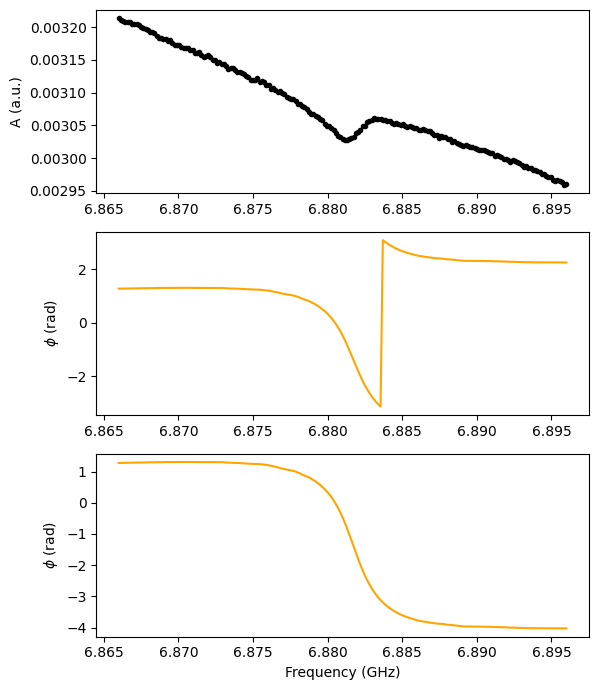

In [29]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = []
for _vl in vl:
    ax1.axvline(vl, ls='-', color='tab:blue')
    ax2.axvline(vl, ls='-', color='tab:blue')
    ax3.axvline(vl, ls='-', color='tab:blue')

plt.tight_layout()
plt.show()

## Resonator vs flux 

### resonator spectroscopy setup

In [31]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -20e6
stop_freq = 15e6
num_points = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

readout_pulse = create_readout_pulse(measure_q)

In [32]:
2**10

1024

In [33]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=977580000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.03,
│   │   │   'reset_length': 5e-06
│   │   }
│   )
)

#### 3.2.2 Experiment Definition

In [34]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [35]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [36]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [37]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.08.01 12:13:46.463] INFO    Starting LabOne Q Compiler run...
[2024.08.01 12:13:46.473] INFO    Schedule completed. [0.008 s]
[2024.08.01 12:13:46.499] INFO    Code generation completed for all AWGs. [0.024 s]
[2024.08.01 12:13:46.500] INFO    Completed compilation step 1 of 1. [0.035 s]
[2024.08.01 12:13:46.503] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 12:13:46.504] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 12:13:46.506] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 12:13:46.507] INFO      device_shfqc     0         23            0           1      8000  
[2024.08.01 12:13:46.508] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 12:13:46.509] INFO      TOTAL                      23            0                  8000  
[2024.08.01 12:13:46.510] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-08-01-12-13-46.html

#### 3.2.4 Run and Evaluate Experiment

In [38]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.08.01 12:13:49.731] INFO    Configuring the device setup
[2024.08.01 12:13:49.847] INFO    The device setup is configured
[2024.08.01 12:13:50.856] INFO    Starting near-time execution...
[2024.08.01 12:13:52.554] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240801T121352.json


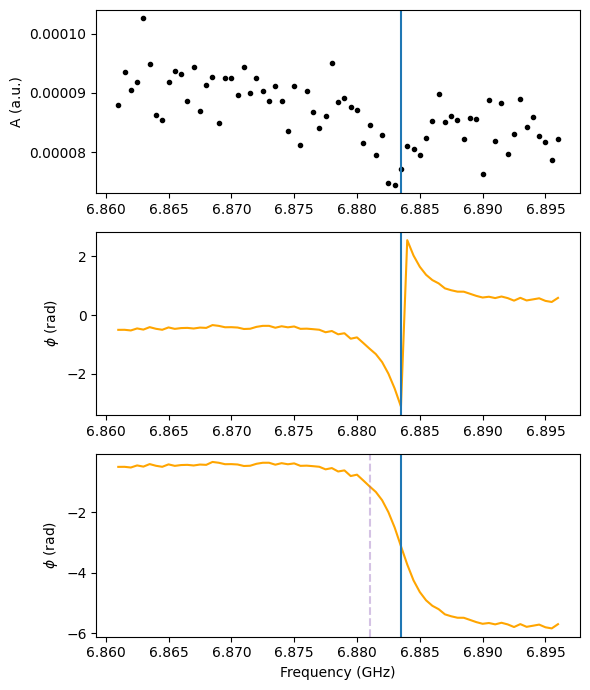

In [47]:
electrical_delay = 60.64e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.8835]
for _vl in vl:
    ax1.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax2.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax3.axvline(_vl, ls='-', 
                # color='tab:blue',
               )

plt.tight_layout()

plt.axvline(measure_q.parameters.readout_resonator_frequency*1e-9, alpha=0.4, ls='--', color='tab:purple')

In [48]:
measure_q.parameters.readout_resonator_frequency = 6.8835e9
device_setup.set_calibration(
    measure_q.calibration()
)

In [49]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=977580000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6883500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.03,
│   │   │   'reset_length': 5e-06
│   │   }
│   )
)

### f_r vs phi ext

In [51]:
del dc

In [26]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc_q1 = GS200('yoko_q1', address = 'GPIB00::15::INSTR')

Connected to: YOKOGAWA GS210 (serial:91P925820, firmware:2.02) in 0.70s


In [53]:
dc_q1.off()
dc_q1.output('off')
dc_q1.source_mode('CURR')
dc_q1.ramp_current(0e-3, 1e-6,0)

In [92]:
dc_q1.output('off')
dc_q1.source_mode('CURR')

In [93]:
import sys

In [122]:
dc_q1.ramp_current(0, 1e-6, 0)

In [54]:
dc_q1.output('on')

In [58]:
dc_q1.ramp_current(0e-3, 1e-6, 0)

In [55]:
plot = False  # plot individual resonator spectroscopy
dc_q1.current_range(0.2)

start_curr = 3.0e-3
stop_curr = 15e-3
current_sweep = np.linspace(start_curr,stop_curr, 151)

dc_q1.ramp_current(0e-3, 1e-6, 0)

dc_q1.output('off')
dc_q1.source_mode('CURR')

dc_q1.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc_q1.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

step 0
current: 0.003
[2024.08.01 12:19:21.217] INFO    Configuring the device setup
[2024.08.01 12:19:21.325] INFO    The device setup is configured
[2024.08.01 12:19:22.143] INFO    Starting near-time execution...
[2024.08.01 12:19:23.818] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240801T121923.json
step 1
current: 0.0030800000000000003
[2024.08.01 12:19:26.323] INFO    Starting near-time execution...
[2024.08.01 12:19:27.888] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240801T121928.json
step 2
current: 0.00316
[2024.08.01 12:19:30.514] INFO    Starting near-time execution...
[2024.08.01 12:19:32.139] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240801T121932.json
step 3
current: 0.0032400000000000003
[2024.08.01 12:19:34.362] INFO    Starting near-time execution...
[2024.08.01 12:19:36.054] INFO    Finished near-time execution.
File saved as Result

Text(0.5, 1.0, 'LogMag [arb.]')

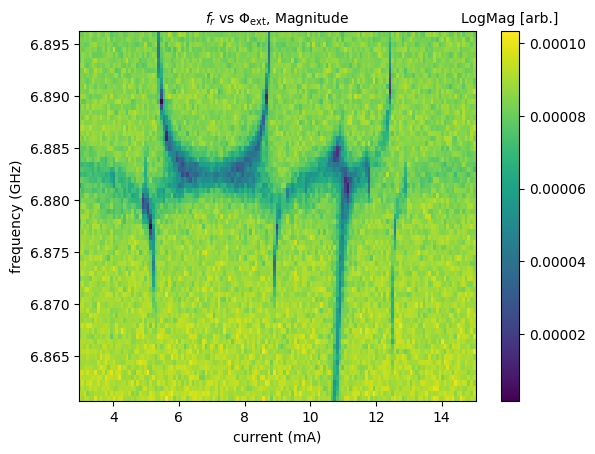

In [56]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

Text(0.5, 1.0, 'Phase [rad]')

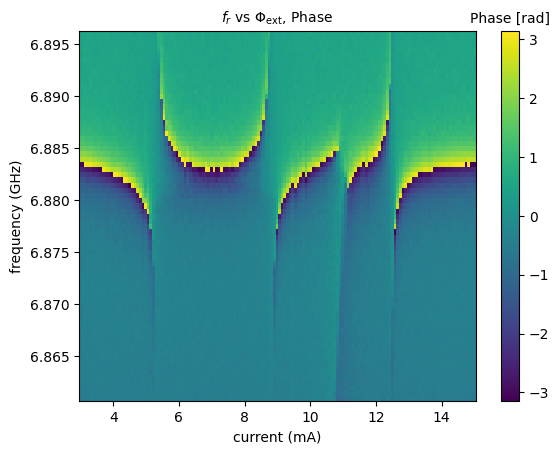

In [57]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
# plt.axvline(8.8, c='tab:blue', alpha=0.4)
# plt.axhline(6.818, c='tab:purple', alpha=0.4)

# fine resonator spectroscopy around half flux

In [59]:
plot = False  # plot individual resonator spectroscopy
dc_q1.current_range(0.2)

start_curr = 5.0e-3
stop_curr = 9e-3
current_sweep = np.linspace(start_curr,stop_curr, 351)

dc_q1.ramp_current(0e-3, 1e-6, 0)

dc_q1.output('off')
dc_q1.source_mode('CURR')

dc_q1.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc_q1.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

dc_q1.ramp_current(0e-3, 0.2e-6, 0)

step 0
current: 0.005
[2024.08.01 12:37:57.926] INFO    Configuring the device setup
[2024.08.01 12:37:58.039] INFO    The device setup is configured
[2024.08.01 12:37:58.918] INFO    Starting near-time execution...
[2024.08.01 12:38:00.667] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240801T123800.json
step 1
current: 0.005011428571428571
[2024.08.01 12:38:01.985] INFO    Starting near-time execution...
[2024.08.01 12:38:03.665] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240801T123803.json
step 2
current: 0.005022857142857143
[2024.08.01 12:38:05.058] INFO    Starting near-time execution...
[2024.08.01 12:38:06.765] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240801T123806.json
step 3
current: 0.005034285714285714
[2024.08.01 12:38:08.197] INFO    Starting near-time execution...
[2024.08.01 12:38:09.931] INFO    Finished near-time execution.
File save

Text(0.5, 1.0, 'LogMag [arb.]')

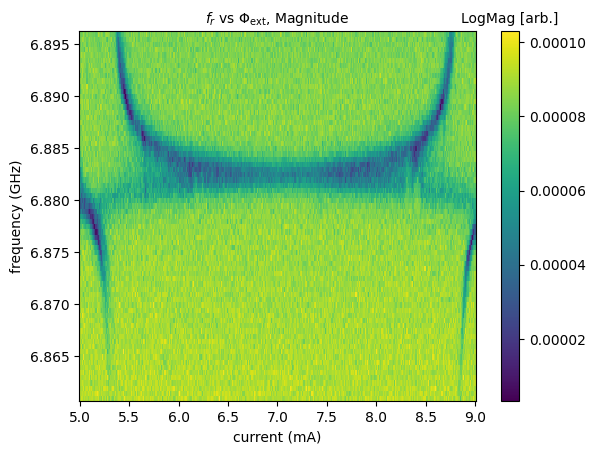

In [60]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

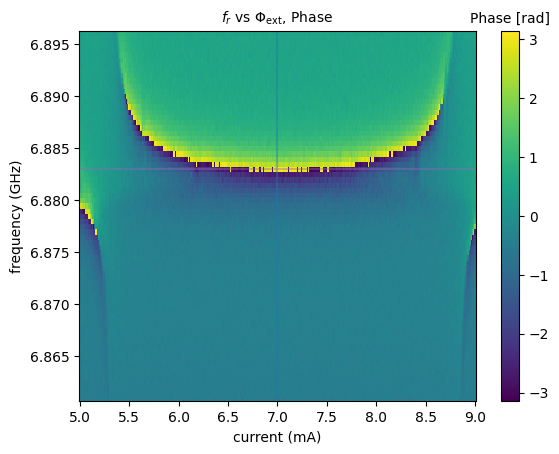

In [66]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(7.0, c='tab:blue', alpha=0.4)
plt.axhline(6.883, c='tab:purple', alpha=0.4)

# Two-tone

In [118]:
print(q0)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=977580000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1200000000.0,
│   │   readout_resonator_frequency=6883500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-20,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.03,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [121]:
from copy import deepcopy

In [123]:
# print(q1)
q1.parameters.resonance_frequency_ge = deepcopy(q0.parameters.resonance_frequency_ge)
q1.parameters.drive_lo_frequency = deepcopy(q0.parameters.drive_lo_frequency)
q1.parameters.readout_resonator_frequency = deepcopy(q0.parameters.readout_resonator_frequency)
q1.parameters.readout_lo_frequency = deepcopy(q0.parameters.readout_lo_frequency)
q1.parameters.readout_integration_delay = deepcopy(q0.parameters.readout_integration_delay)
q1.parameters.drive_range = deepcopy(q0.parameters.drive_range)
q1.parameters.readout_range_out = deepcopy(q0.parameters.readout_range_out)
q1.parameters.readout_range_in = deepcopy(q0.parameters.readout_range_in)
q1.parameters.user_defined = deepcopy(q0.parameters.user_defined)
print(q1)

Transmon(
│   uid='q1',
│   signals={'drive': '/logical_signal_groups/q1/drive_line', 'measure': '/logical_signal_groups/q1/measure_line', 'acquire': '/logical_signal_groups/q1/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=977580000.0,
│   │   resonance_frequency_ef=5950000000.0,
│   │   drive_lo_frequency=1200000000.0,
│   │   readout_resonator_frequency=6883500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-20,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.03,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [124]:
measure_q = q1

In [68]:
dc_q1.ramp_current(7.0e-3, 1e-6, 0)

In [1476]:
dc.output('on')

In [212]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
qspec_num = 501
# qspec_num = 201

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 11

In [213]:
### QB spec
measure_q.parameters.drive_lo_frequency = 1.4e9

LF_path = False
start_freq = -50e6
stop_freq = 950e6
# measure_q.parameters.resonance_frequency_ge = 1.161e9
# measure_q.parameters.user_defined['amplitude_pi'] = 0.99
# measure_q.parameters.user_defined['amplitude_pi'] = 0.01

### RO spec
# measure_q.parameters.readout_resonator_frequency = 6.816e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3

# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

measure_q.parameters.drive_range = -10
# measure_q.parameters.drive_range = 0
# measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['reset_length'] = 0.5e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 1000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q1',
│   signals={'drive': '/logical_signal_groups/q1/drive_line', 'measure': '/logical_signal_groups/q1/measure_line', 'acquire': '/logical_signal_groups/q1/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=977580000.0,
│   │   resonance_frequency_ef=5950000000.0,
│   │   drive_lo_frequency=1400000000.0,
│   │   readout_resonator_frequency=6883500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.03,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [214]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [215]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [216]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [217]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q, amp=0.4)
# drive_pulse = create_rabi_drive_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [218]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(5e-07,
 LinearSweepParameter(uid='drive_freq_q1', start=-472420000.0, stop=527580000.0, count=501, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q1', amplitude=0.4, length=1e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q1', amplitude=0.03, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [219]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.08.01 14:00:31.094] INFO    Starting LabOne Q Compiler run...
[2024.08.01 14:00:31.155] INFO    Schedule completed. [0.057 s]
[2024.08.01 14:00:31.499] INFO    Code generation completed for all AWGs. [0.342 s]
[2024.08.01 14:00:31.501] INFO    Completed compilation step 1 of 1. [0.404 s]
[2024.08.01 14:00:31.505] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 14:00:31.506] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 14:00:31.507] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 14:00:31.509] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.01 14:00:31.510] INFO      device_shfqc_sg     2         22            1           1      4000  
[2024.08.01 14:00:31.511] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 14:00:31.512] INFO      TOTAL                         32 

In [220]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.01 14:00:31.523] INFO    Configuring the device setup
[2024.08.01 14:00:31.631] INFO    The device setup is configured
[2024.08.01 14:00:32.584] INFO    Starting near-time execution...
[2024.08.01 14:00:37.045] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T140037.json


In [221]:
emulate=False

estimated frequency 0.96958 GHz


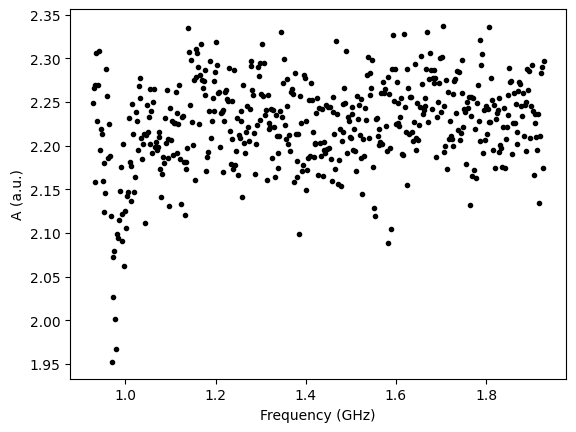

In [222]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

# plt.axvline(1.162, linestyle = '--', alpha=0.4)
# plt.axvline(1.14, linestyle = '--', alpha=0.4)
# plt.axvline(1.191, linestyle = '--', alpha=0.4)
# plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

In [85]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=977580000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1200000000.0,
│   │   readout_resonator_frequency=6883500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-20,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.03,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [1494]:
measure_q.parameters.resonance_frequency_ge = 1.1607e9
device_setup.set_calibration(
    measure_q.calibration()
)

In [981]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6816000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=0,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.1,
│   │   │   'pulse_length': 4e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

## Two-tone vs flux
Fine two tone sweep to find half-flux

[2024.08.01 14:34:46.694] INFO    Configuring the device setup
[2024.08.01 14:34:46.813] INFO    The device setup is configured
[2024.08.01 14:34:47.838] INFO    Starting near-time execution...
[2024.08.01 14:34:52.389] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T143452.json
[2024.08.01 14:34:54.353] INFO    Starting near-time execution...
[2024.08.01 14:34:58.860] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T143459.json
[2024.08.01 14:35:00.710] INFO    Starting near-time execution...
[2024.08.01 14:35:05.224] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T143505.json
[2024.08.01 14:35:07.170] INFO    Starting near-time execution...
[2024.08.01 14:35:11.670] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T143511.json
[2024.08.01 14:35:13.399] INFO    Starting near-time execution...
[2024.08.01 14:35:17.959] INFO

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_120752\3449076277.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


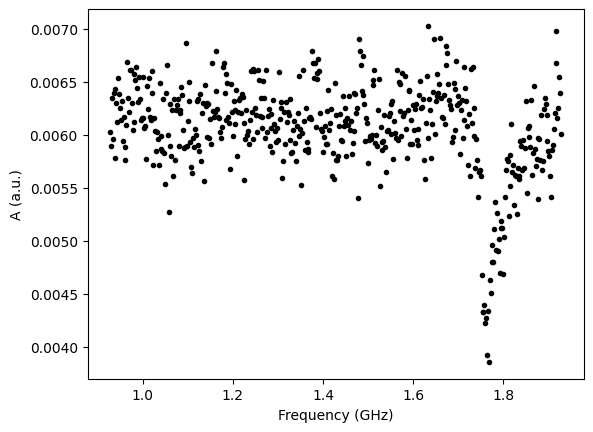

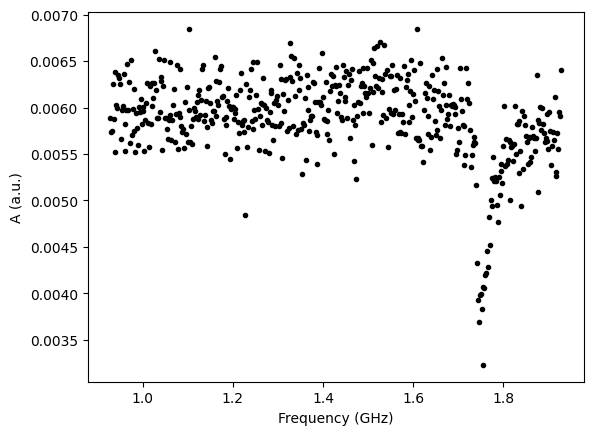

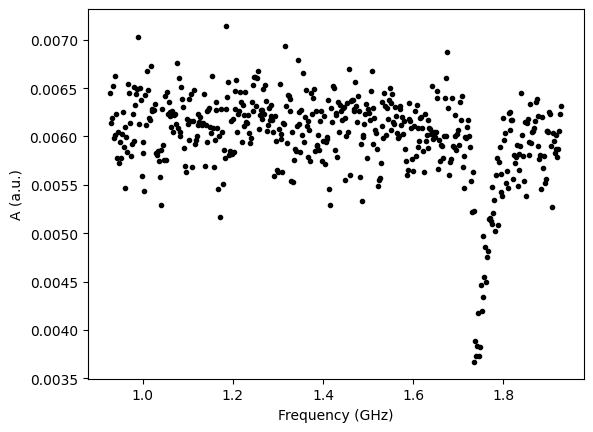

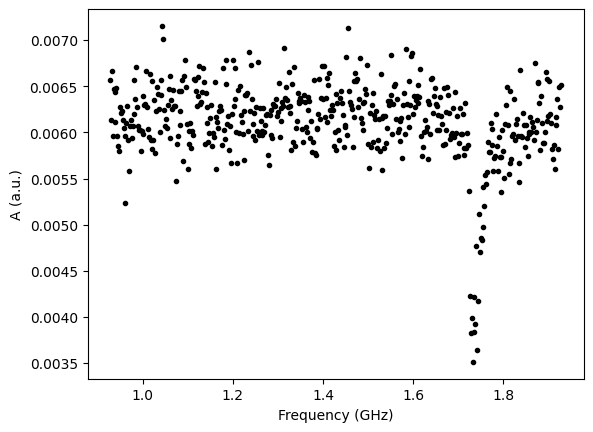

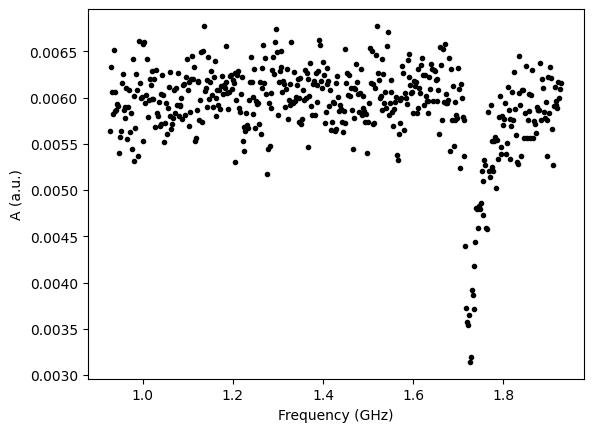

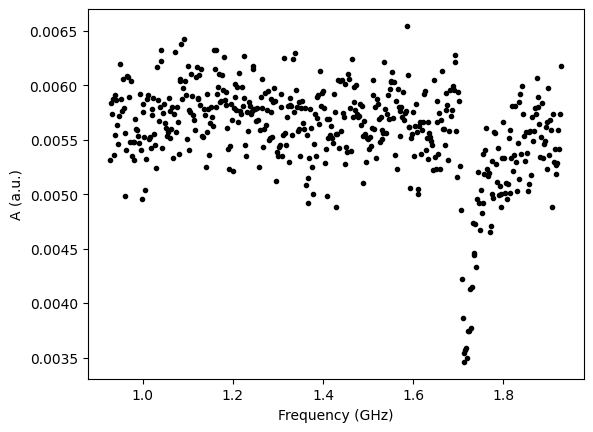

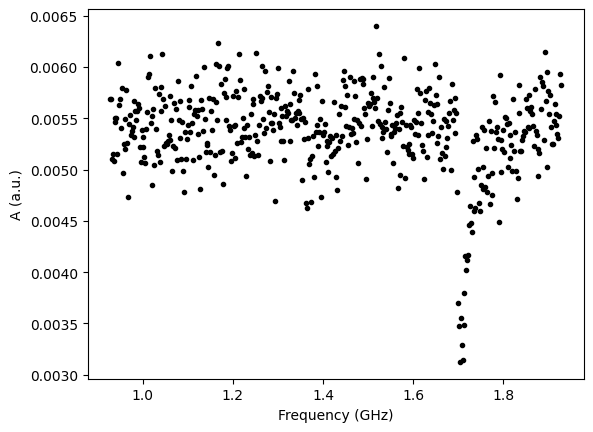

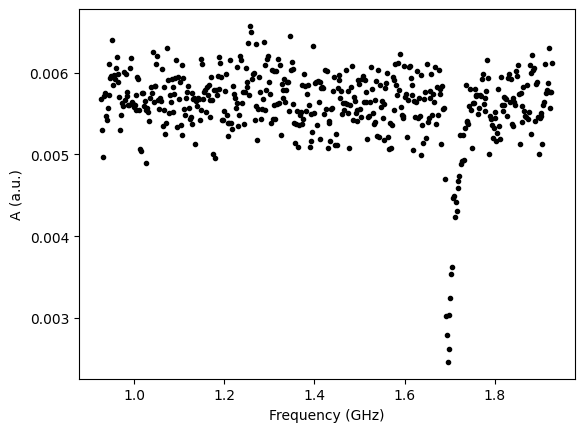

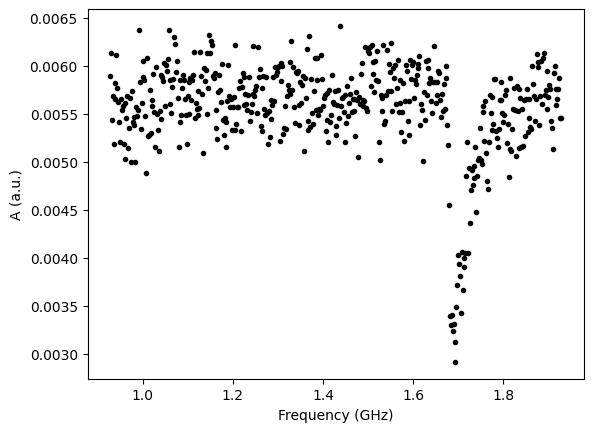

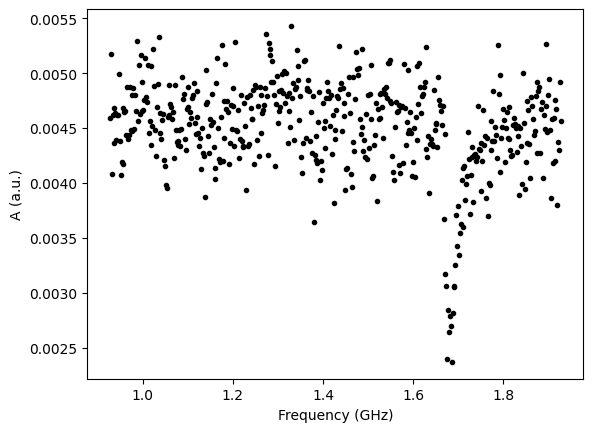

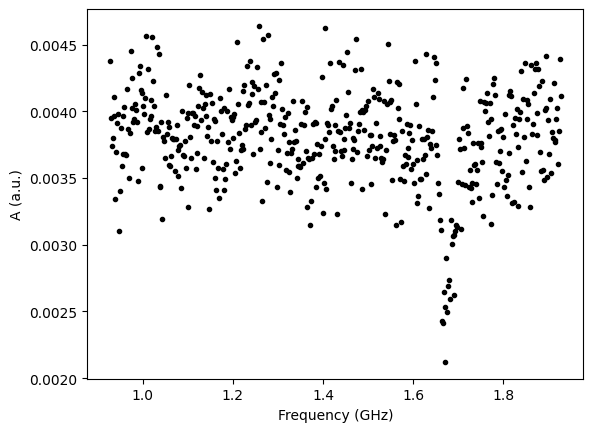

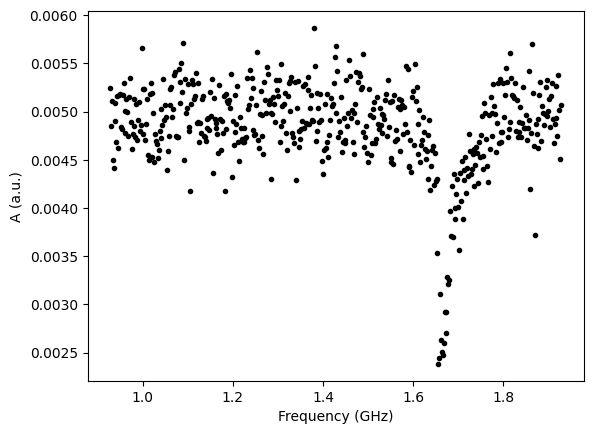

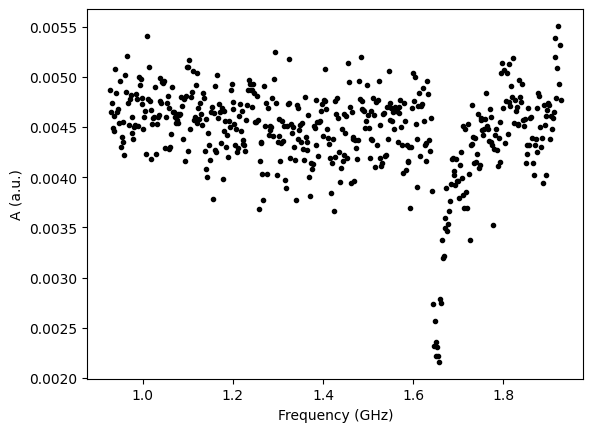

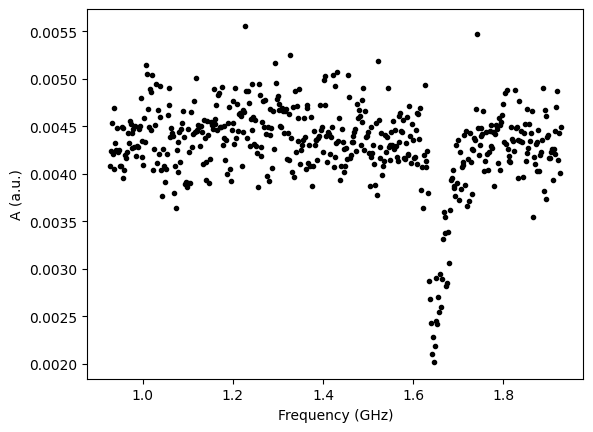

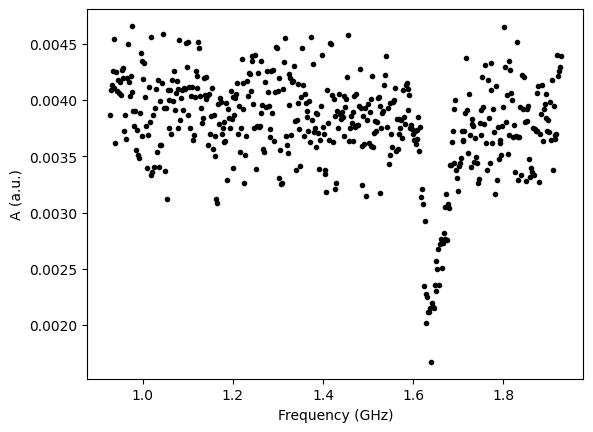

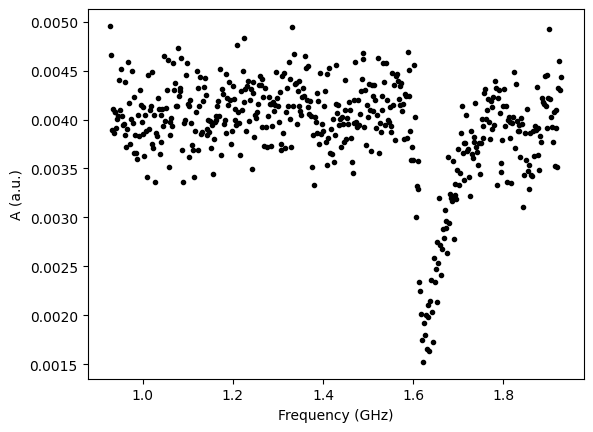

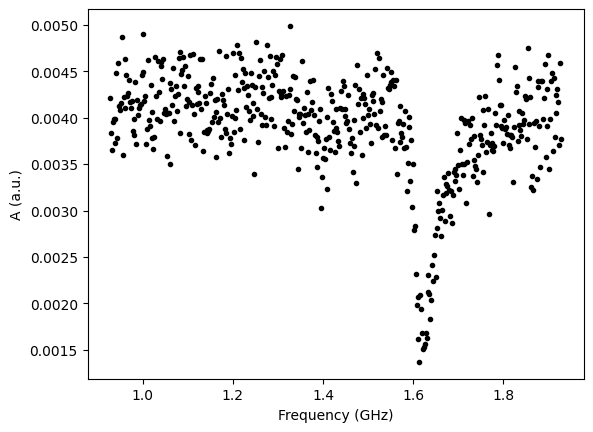

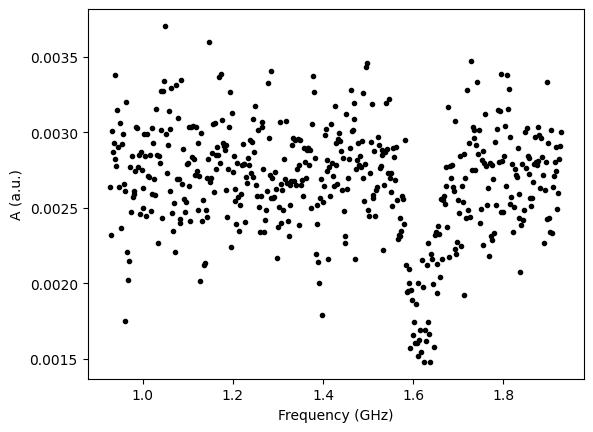

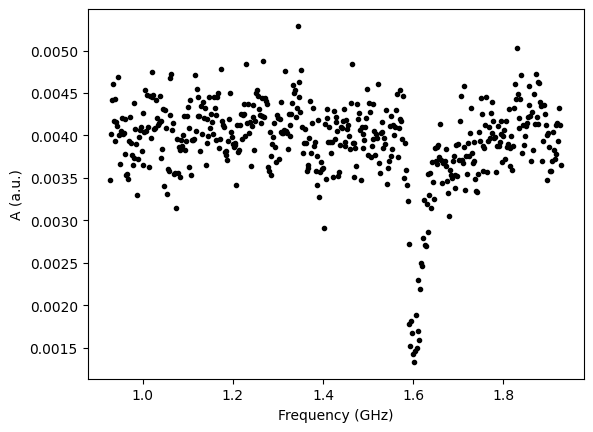

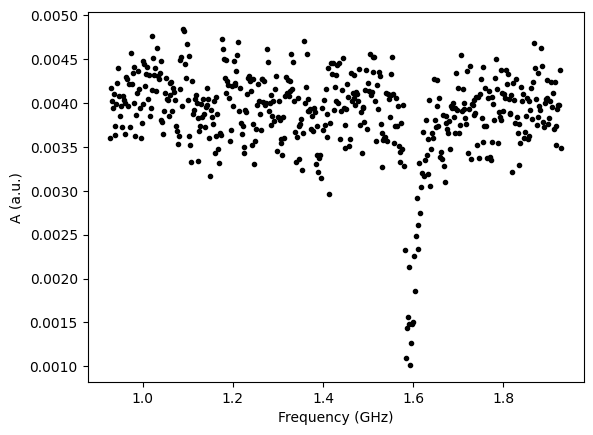

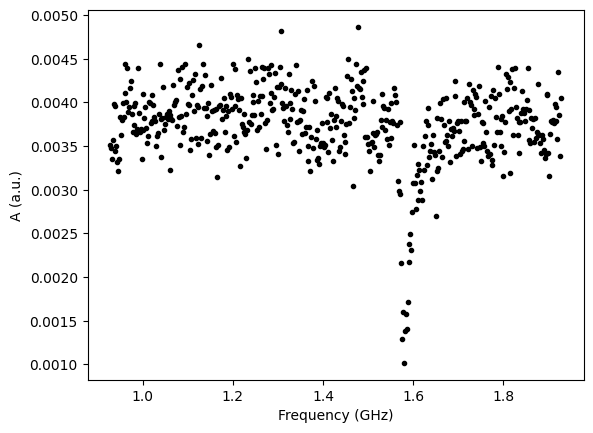

In [339]:
# dc.current_range(1e-3)
start = 5.8e-3
stop = 6.0e-3

current_sweep = np.linspace(start, stop, 21)
dc_q1.output('on')
sweep_qspec_results = []
for current in current_sweep:
    dc_q1.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)
    # run the experiment on qubit 0
    qspec_results = session.run()

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    sweep_qspec_results.append(qspec_res)

    # plot measurement data
    fig = plt.figure()
    plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
    plt.ylabel("A (a.u.)")
    plt.xlabel("Frequency (GHz)")

# plt.show()
# dc.ramp_current(5.5e-3,1e-5,0)

Text(0.5, 1.0, 'mag')

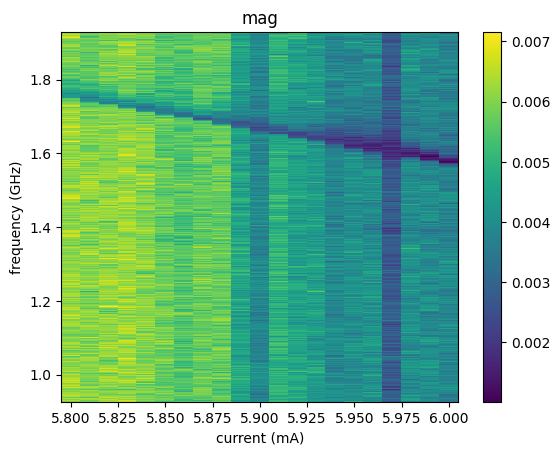

In [340]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

In [341]:
angle_data = np.unwrap(np.angle(sweep_qspec_results).T)
angle_data[(angle_data > 1)] = np.nan
norm = np.array(angle_data) - np.nanmedian(angle_data, axis=0)
norm = np.abs(norm)

In [342]:
# for col in norm.T:
#     plt.figure()
#     plt.plot(col)

Text(0.5, 1.0, 'phase')

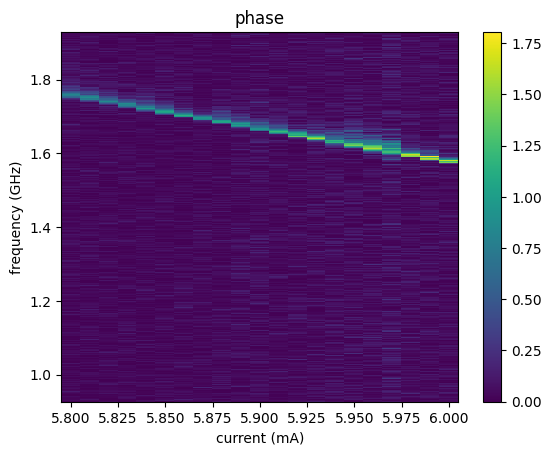

In [343]:
# plt.pcolor( current_sweep*1e3,qspec_freq/1e9, angle_data)
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, norm)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(08.84)
# plt.axhline(1.1629, color='tab:orange')
# current_sweep[8]*1e3

In [344]:
ams = []
ms = []
for col in norm.T:
    ams.append(np.nanargmax(col))
    ms.append(np.nanmax(col))

In [345]:
peaks_loc = np.nanargmax(norm, axis=0)

In [346]:
peak_freq = (qspec_freq/1e9)[peaks_loc]

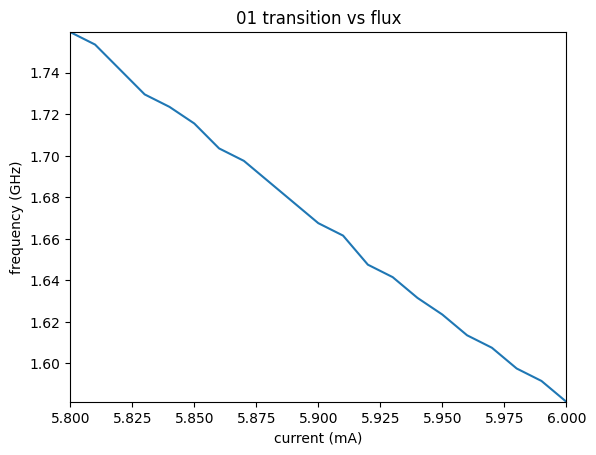

In [347]:
plt.plot(current_sweep*1e3, peak_freq)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('01 transition vs flux')
plt.margins(x=0, y=0)

In [349]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(current_sweep*1e3,peak_freq)

In [350]:
slope

-0.8981818181818152

## Move Q0 to linear fluxon regime

In [354]:
q0.parameters.resonance_frequency_ge=1162600000.0
q0.parameters.resonance_frequency_ef=2950000000.0
q0.parameters.drive_lo_frequency=1300000000.0
q0.parameters.readout_resonator_frequency=6816000000.0
q0.parameters.readout_lo_frequency=6500000000.0
q0.parameters.readout_integration_delay=6e-08
q0.parameters.drive_range=5
q0.parameters.readout_range_out=-30
q0.parameters.readout_range_in=-15
q0.parameters.flux_offset_voltage=0
q0.parameters.user_defined={
'amplitude_pi': 0.6,
'pulse_length': 4e-06,
'readout_len': 2e-06,
'readout_amp': 0.3,
'reset_length': 0.0001,
}

In [355]:
print(q0)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1162600000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6816000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.6,
│   │   │   'pulse_length': 4e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [356]:
measure_q = q0

In [358]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc_q0 = GS200('yoko_q0', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.02s


### resonator spectroscopy

In [359]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -20e6
stop_freq = 15e6
num_points = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

readout_pulse = create_readout_pulse(measure_q)

In [360]:
2**10

1024

In [361]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1162600000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6816000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.6,
│   │   │   'pulse_length': 4e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

#### 3.2.2 Experiment Definition

In [362]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [363]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [364]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [365]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.08.01 14:51:18.771] INFO    Starting LabOne Q Compiler run...
[2024.08.01 14:51:18.784] INFO    Schedule completed. [0.010 s]
[2024.08.01 14:51:18.812] INFO    Code generation completed for all AWGs. [0.025 s]
[2024.08.01 14:51:18.816] INFO    Completed compilation step 1 of 1. [0.041 s]
[2024.08.01 14:51:18.820] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 14:51:18.824] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 14:51:18.827] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 14:51:18.831] INFO      device_shfqc     0         23            0           1      8000  
[2024.08.01 14:51:18.835] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.01 14:51:18.839] INFO      TOTAL                      23            0                  8000  
[2024.08.01 14:51:18.843] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-08-01-14-51-18.html

#### 3.2.4 Run and Evaluate Experiment

In [366]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.08.01 14:51:19.238] INFO    Configuring the device setup
[2024.08.01 14:51:19.357] INFO    The device setup is configured
[2024.08.01 14:51:20.224] INFO    Starting near-time execution...
[2024.08.01 14:51:21.895] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240801T145122.json


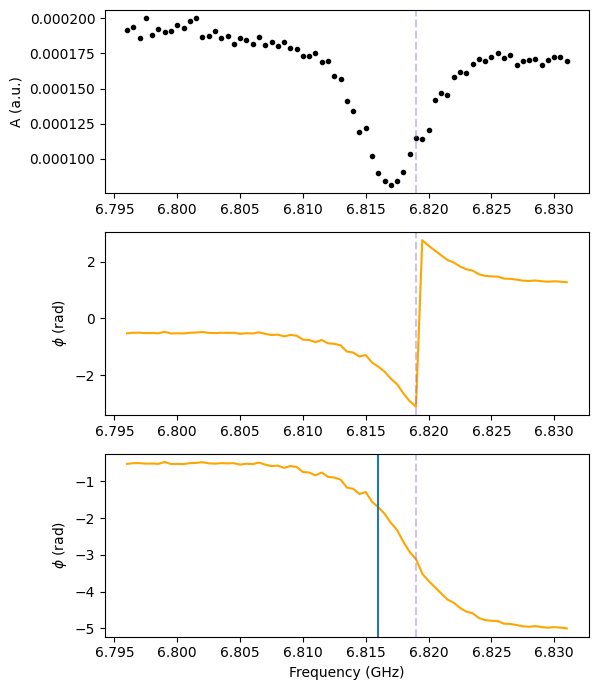

In [371]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.819]
for _vl in vl:
    ax1.axvline(_vl, ls='--', 
                color='tab:purple',
                alpha=0.4,
               )
    ax2.axvline(_vl, ls='--', 
                color='tab:purple',
                alpha=0.4,
               )
    ax3.axvline(_vl, ls='--', 
                color='tab:purple',
                alpha=0.4,
               )

plt.tight_layout()

plt.axvline(measure_q.parameters.readout_resonator_frequency*1e-9)

In [372]:
measure_q.parameters.readout_resonator_frequency = 6.819e9

### two tone

In [897]:
dc_q0.ramp_current(7.95e-3, 1e-6, 0)

In [898]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
qspec_num = 401

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

In [899]:
### QB spec
measure_q.parameters.drive_lo_frequency = 1.0e9

LF_path = False
start_freq = -50e6
stop_freq = 50e6
measure_q.parameters.resonance_frequency_ge = 0.71e9
# measure_q.parameters.user_defined['amplitude_pi'] = 0.99
# measure_q.parameters.user_defined['amplitude_pi'] = 0.01

### RO spec
# measure_q.parameters.readout_resonator_frequency = 6.816e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3

# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

measure_q.parameters.drive_range = -20
# measure_q.parameters.drive_range = 0
# measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['reset_length'] = 0.5e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 4000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=710000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-20,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 4e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [900]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [901]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [902]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [903]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q, amp=0.4)
# drive_pulse = create_rabi_drive_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [904]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(5e-07,
 LinearSweepParameter(uid='drive_freq_q0', start=-340000000.0, stop=-240000000.0, count=401, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q0', amplitude=0.4, length=4e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q0', amplitude=0.3, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [905]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.08.01 17:13:25.519] INFO    Starting LabOne Q Compiler run...
[2024.08.01 17:13:25.559] INFO    Schedule completed. [0.038 s]
[2024.08.01 17:13:25.916] INFO    Code generation completed for all AWGs. [0.354 s]
[2024.08.01 17:13:25.918] INFO    Completed compilation step 1 of 1. [0.395 s]
[2024.08.01 17:13:25.922] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:13:25.923] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 17:13:25.924] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:13:25.925] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.01 17:13:25.927] INFO      device_shfqc_sg     0         22            1           1     16000  
[2024.08.01 17:13:25.928] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:13:25.929] INFO      TOTAL                         32 

In [906]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.01 17:13:25.947] INFO    Configuring the device setup
[2024.08.01 17:13:26.061] INFO    The device setup is configured
[2024.08.01 17:13:26.921] INFO    Starting near-time execution...
[2024.08.01 17:13:27.450] INFO    Estimated RT execution time: 21.65 s.
[2024.08.01 17:13:49.360] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T171349.json


In [907]:
emulate=False

estimated frequency 0.70925 GHz


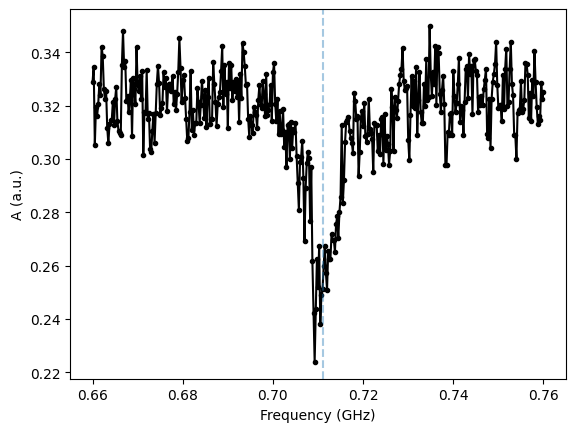

In [908]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

In [581]:
measure_q.parameters.resonance_frequency_ge = 0.711e9

## Two-tone vs flux
Fine two tone sweep to find half-flux

In [833]:
# dc.current_range(1e-3)
start = 7.85e-3
stop = 8.05e-3

current_sweep = np.linspace(start, stop, 41)
dc_q0.output('on')
sweep_qspec_results = []
for current in current_sweep:
    dc_q0.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)
    # run the experiment on qubit 0
    qspec_results = session.run()

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    sweep_qspec_results.append(qspec_res)

    # plot measurement data
    # fig = plt.figure()
    # plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
    # plt.ylabel("A (a.u.)")
    # plt.xlabel("Frequency (GHz)")

# plt.show()
# dc.ramp_current(5.5e-3,1e-5,0)

[2024.08.01 16:50:40.445] INFO    Configuring the device setup
[2024.08.01 16:50:40.559] INFO    The device setup is configured
[2024.08.01 16:50:41.318] INFO    Starting near-time execution...
[2024.08.01 16:50:45.850] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T165045.json
[2024.08.01 16:50:47.663] INFO    Starting near-time execution...
[2024.08.01 16:50:52.191] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T165052.json
[2024.08.01 16:50:53.979] INFO    Starting near-time execution...
[2024.08.01 16:50:58.560] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T165058.json
[2024.08.01 16:51:00.249] INFO    Starting near-time execution...
[2024.08.01 16:51:04.861] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T165105.json
[2024.08.01 16:51:06.618] INFO    Starting near-time execution...
[2024.08.01 16:51:11.173] INFO

Text(0.5, 1.0, 'mag')

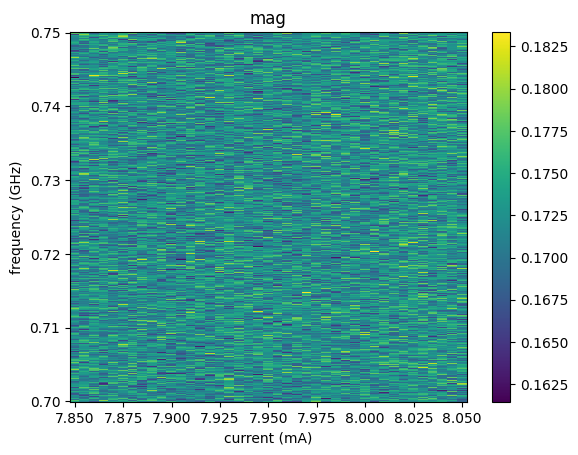

In [834]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

In [835]:
angle_data = np.abs(np.unwrap(np.angle(sweep_qspec_results).T))
# for col in angle_data.T:
#     plt.figure()
#     plt.plot(col)

In [836]:
thresh_low = -2
thresh_high = 2
norm = np.array(angle_data) - np.nanmedian(angle_data, axis=0)
norm[(norm > thresh_high) | (norm < thresh_low)] = np.nan

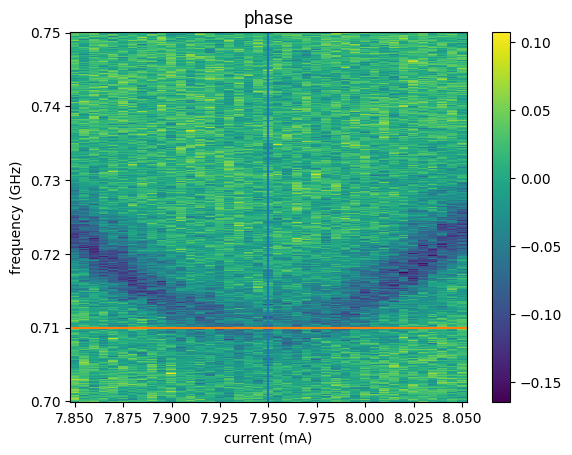

In [842]:
# plt.pcolor( current_sweep*1e3,qspec_freq/1e9, angle_data)
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, norm)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
plt.axvline(7.95)
plt.axhline(0.71, color='tab:orange')
# current_sweep[8]*1e3

In [ ]:
for i, col in enumerate(norm.T):
    plt.figure()
    plt.plot(qspec_freq/1e9, col)
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('Digitizer voltage (arb.)')
    plt.margins(x=0)
    plt.title(f'Current = {np.round(current_sweep[i]*1e3, 4)} mA')

In [839]:
peaks_loc = np.nanargmin(norm, axis=0)

In [840]:
peak_freq = (qspec_freq/1e9)[peaks_loc]

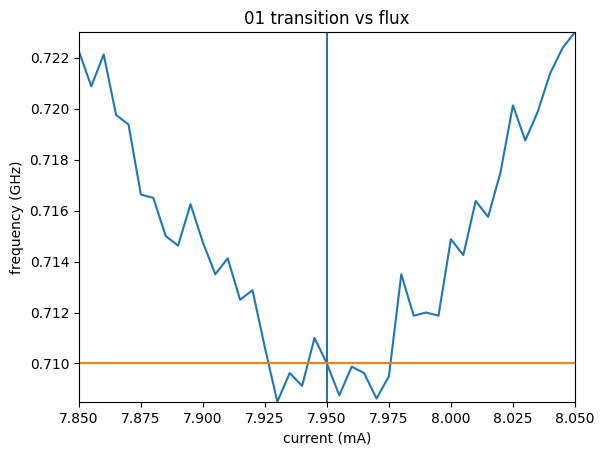

In [845]:
plt.plot(current_sweep*1e3, peak_freq)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('01 transition vs flux')
plt.margins(x=0, y=0)
plt.axvline(7.95)
plt.axhline(0.71, color='tab:orange')

In [497]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(current_sweep*1e3,peak_freq)

In [ ]:
slope

## Linear fluxon

### two tone

In [897]:
dc_q0.ramp_current(7.95e-3, 1e-6, 0)

In [973]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
qspec_num = 1001

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

In [974]:
### QB spec
measure_q.parameters.drive_lo_frequency = 1.0e9

LF_path = False
start_freq = -50e6
stop_freq = 700e6
measure_q.parameters.resonance_frequency_ge = 0.71e9
# measure_q.parameters.user_defined['amplitude_pi'] = 0.99
# measure_q.parameters.user_defined['amplitude_pi'] = 0.01

### RO spec
# measure_q.parameters.readout_resonator_frequency = 6.816e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3

# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

measure_q.parameters.drive_range = -15
# measure_q.parameters.drive_range = 0
# measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['reset_length'] = 0.5e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 2000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=710000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-15,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.39,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [975]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [976]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [977]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [978]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q, amp=0.4)
# drive_pulse = create_rabi_drive_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [979]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(5e-07,
 LinearSweepParameter(uid='drive_freq_q0', start=-340000000.0, stop=410000000.0, count=1001, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q0', amplitude=0.4, length=2e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q0', amplitude=0.3, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [980]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.08.01 17:28:42.983] INFO    Starting LabOne Q Compiler run...
[2024.08.01 17:28:43.084] INFO    Schedule completed. [0.099 s]
[2024.08.01 17:28:43.792] INFO    Code generation completed for all AWGs. [0.707 s]
[2024.08.01 17:28:43.794] INFO    Completed compilation step 1 of 1. [0.810 s]
[2024.08.01 17:28:43.797] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:28:43.799] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 17:28:43.800] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:28:43.801] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.01 17:28:43.802] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.01 17:28:43.803] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:28:43.804] INFO      TOTAL                         32 

In [981]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.01 17:28:43.817] INFO    Configuring the device setup
[2024.08.01 17:28:43.934] INFO    The device setup is configured
[2024.08.01 17:28:44.874] INFO    Starting near-time execution...
[2024.08.01 17:28:45.411] INFO    Estimated RT execution time: 37.66 s.
[2024.08.01 17:29:23.295] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T172923.json


estimated frequency 0.711 GHz


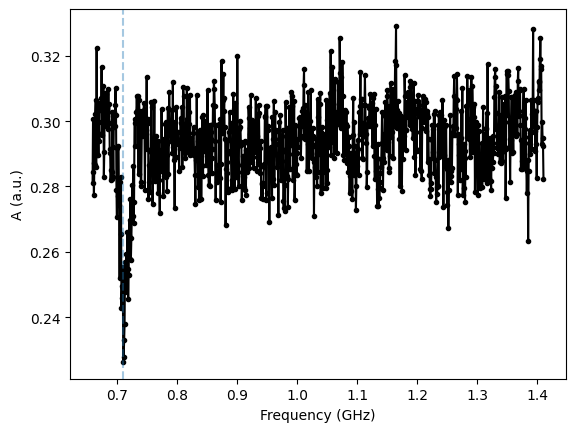

In [982]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

In [581]:
measure_q.parameters.resonance_frequency_ge = 0.711e9

## Two-tone vs flux
Fine two tone sweep to find half-flux

In [983]:
# dc.current_range(1e-3)
start = 6.6e-3
stop = 7.2e-3

current_sweep = np.linspace(start, stop, 41)
dc_q0.output('on')
sweep_qspec_results = []
for current in current_sweep:
    dc_q0.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)
    # run the experiment on qubit 0
    qspec_results = session.run()

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    sweep_qspec_results.append(qspec_res)

    # plot measurement data
    # fig = plt.figure()
    # plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
    # plt.ylabel("A (a.u.)")
    # plt.xlabel("Frequency (GHz)")

# plt.show()
# dc.ramp_current(5.5e-3,1e-5,0)

[2024.08.01 17:30:42.403] INFO    Configuring the device setup
[2024.08.01 17:30:42.511] INFO    The device setup is configured
[2024.08.01 17:30:43.393] INFO    Starting near-time execution...
[2024.08.01 17:30:43.888] INFO    Estimated RT execution time: 37.66 s.
[2024.08.01 17:31:21.793] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T173121.json
[2024.08.01 17:31:23.412] INFO    Starting near-time execution...
[2024.08.01 17:31:23.990] INFO    Estimated RT execution time: 37.66 s.
[2024.08.01 17:32:01.913] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T173202.json
[2024.08.01 17:32:03.873] INFO    Starting near-time execution...
[2024.08.01 17:32:04.373] INFO    Estimated RT execution time: 37.66 s.
[2024.08.01 17:32:42.269] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240801T173242.json
[2024.08.01 17:32:44.196] INFO    Starting near-time execution...
[2024.08

Text(0.5, 1.0, 'mag')

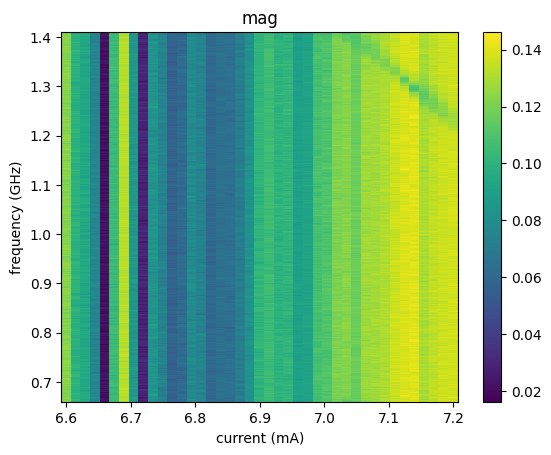

In [984]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

In [985]:
angle_data = np.abs(np.unwrap(np.angle(sweep_qspec_results).T))
# for col in angle_data.T:
#     plt.figure()
#     plt.plot(col)

In [986]:
thresh_low = -2
thresh_high = 2
norm = np.array(angle_data) - np.nanmedian(angle_data, axis=0)
norm[(norm > thresh_high) | (norm < thresh_low)] = np.nan

Text(0.5, 1.0, 'phase')

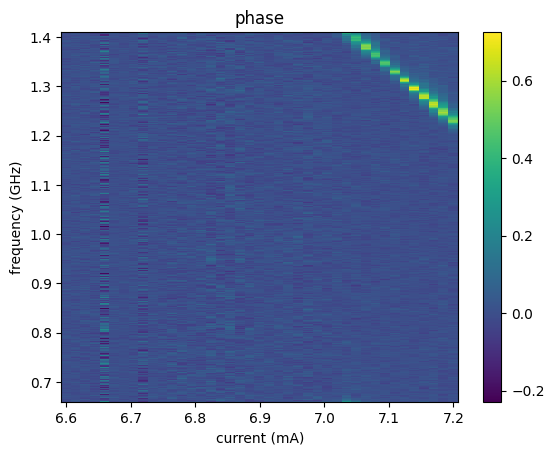

In [993]:
# plt.pcolor( current_sweep*1e3,qspec_freq/1e9, angle_data)
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, norm)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(7.95)
# plt.axhline(0.71, color='tab:orange')
# current_sweep[8]*1e3

In [ ]:
for i, col in enumerate(norm.T[:-3]):
    plt.figure()
    plt.plot(qspec_freq/1e9, col)
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('Digitizer voltage (arb.)')
    plt.margins(x=0)
    plt.title(f'Current = {np.round(current_sweep[i]*1e3, 4)} mA')

In [1002]:
peaks_loc = np.nanargmax(norm, axis=0)

In [997]:
peak_freq = (qspec_freq/1e9)[peaks_loc]

In [1006]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress((current_sweep*1e3)[start:end],peak_freq[start:end])

In [1007]:
slope

-1.0749999999999862

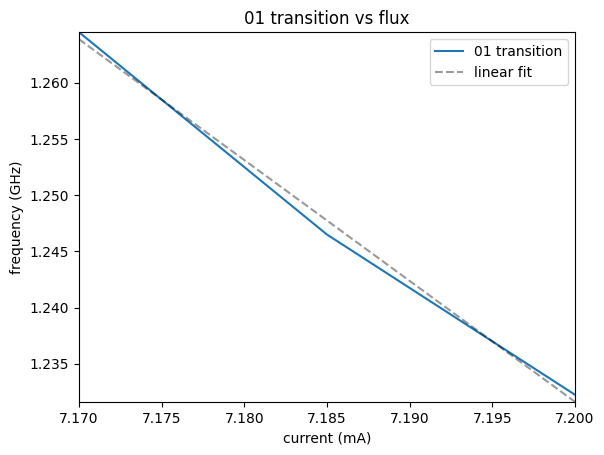

In [1013]:
start = -3
end = None
plt.plot((current_sweep*1e3)[start:end], peak_freq[start:end], label='01 transition')
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('01 transition vs flux')
plt.margins(x=0, y=0)
# plt.axvline(7.95)
# plt.axhline(0.71, color='tab:orange')

plt.plot((current_sweep*1e3)[start:end], slope*(current_sweep*1e3)[start:end] + intercept, ls='--', alpha=0.4, color='k', label='linear fit')

plt.legend()

# Two-qubit flux xtalk experiment

In [49]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc_q1 = GS200('yoko_q1', address = 'GPIB00::15::INSTR')

Connected to: YOKOGAWA GS210 (serial:91P925820, firmware:2.02) in 0.66s


In [50]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc_q0 = GS200('yoko_q0', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.04s


In [68]:
measure_q = q0

In [67]:
q0_current_range = [7.05, 7.2]  # mA
q0_frequency_range = [1.2, 1.4]  # GHz

q1_current_range = [5.8, 6.0]  # mA
q1_frequency_range = [1.5, 1.8]  # GHz

In [1014]:
dc_q0.ramp_current(7.2e-3, 1e-6, 0)

## two tone tuneup: q0

In [69]:
# how many frequency points to measure
qspec_num = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

In [70]:
### QB spec

start_freq = -150e6
stop_freq = 150e6
measure_q.parameters.resonance_frequency_ge = 1.3e9
# measure_q.parameters.user_defined['amplitude_pi'] = 0.99
# measure_q.parameters.user_defined['amplitude_pi'] = 0.01

### RO spec
# measure_q.parameters.readout_resonator_frequency = 6.816e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3

# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

measure_q.parameters.drive_range = -15
# measure_q.parameters.drive_range = 0
# measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['reset_length'] = 0.5e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 2000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1300000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-15,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.39,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [71]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [72]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [73]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [74]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q, amp=0.4)
# drive_pulse = create_rabi_drive_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec_q0 = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec_q0.set_calibration(exp_calibration_q)
exp_qspec_q0.set_signal_map(signal_map_default(measure_q))

In [75]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(5e-07,
 LinearSweepParameter(uid='drive_freq_q0', start=150000000.0, stop=450000000.0, count=71, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q0', amplitude=0.4, length=2e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q0', amplitude=0.3, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [76]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec_q0)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.08.02 11:43:29.329] INFO    Starting LabOne Q Compiler run...
[2024.08.02 11:43:29.352] INFO    Schedule completed. [0.019 s]
[2024.08.02 11:43:29.488] INFO    Code generation completed for all AWGs. [0.134 s]
[2024.08.02 11:43:29.490] INFO    Completed compilation step 1 of 1. [0.158 s]
[2024.08.02 11:43:29.498] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 11:43:29.500] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 11:43:29.502] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 11:43:29.504] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 11:43:29.506] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 11:43:29.508] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 11:43:29.509] INFO      TOTAL                         32 

In [77]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.02 11:43:29.527] INFO    Configuring the device setup
[2024.08.02 11:43:29.632] INFO    The device setup is configured
[2024.08.02 11:43:30.561] INFO    Starting near-time execution...
[2024.08.02 11:43:31.664] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240802T114331.json


estimated frequency 1.227142857142857 GHz


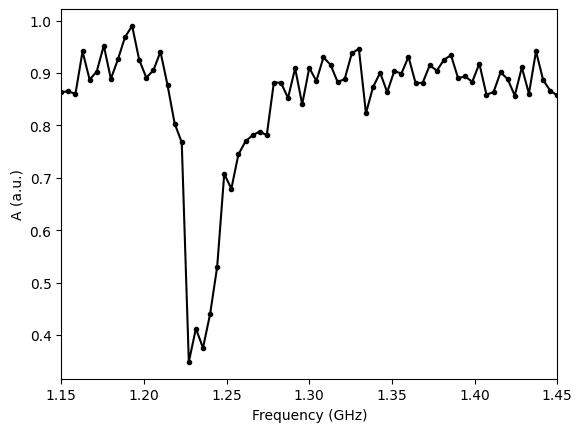

In [78]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.margins(x=0)

# plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

## two tone tuneup: q1

In [109]:
measure_q = q1

In [110]:
dc_q1.ramp_current(5.9e-3, 1e-6, 0)

In [133]:
# how many frequency points to measure
qspec_num = 271

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

In [134]:
q1?

Transmon(
│   uid='q1',
│   signals={'drive': '/logical_signal_groups/q1/drive_line', 'measure': '/logical_signal_groups/q1/measure_line', 'acquire': '/logical_signal_groups/q1/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1650000000.0,
│   │   resonance_frequency_ef=5950000000.0,
│   │   drive_lo_frequency=1400000000.0,
│   │   readout_resonator_frequency=6883500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.03,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

In [135]:
### QB spec

start_freq = -400e6
stop_freq = 400e6
measure_q.parameters.resonance_frequency_ge = 1.65e9

### RO spec
# measure_q.parameters.readout_resonator_frequency = 6.816e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3

# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

# measure_q.parameters.drive_range = -15
# measure_q.parameters.drive_range = 0
# measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['reset_length'] = 0.5e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
# measure_q.parameters.user_defined['pulse_length'] = 2000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q1',
│   signals={'drive': '/logical_signal_groups/q1/drive_line', 'measure': '/logical_signal_groups/q1/measure_line', 'acquire': '/logical_signal_groups/q1/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1650000000.0,
│   │   resonance_frequency_ef=5950000000.0,
│   │   drive_lo_frequency=1400000000.0,
│   │   readout_resonator_frequency=6883500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.03,
│   │   │   'reset_length': 5e-07
│   │   }
│   )
)

In [136]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [118]:
num_averages

11

In [340]:
num_averages = 13

In [341]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [138]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [139]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q, amp=0.4)
# drive_pulse = create_rabi_drive_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec_q1 = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec_q1.set_calibration(exp_calibration_q)
exp_qspec_q1.set_signal_map(signal_map_default(measure_q))

In [140]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(5e-07,
 LinearSweepParameter(uid='drive_freq_q1', start=-150000000.0, stop=650000000.0, count=271, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q1', amplitude=0.4, length=1e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q1', amplitude=0.03, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [141]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec_q1)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.08.02 11:59:28.350] INFO    Starting LabOne Q Compiler run...
[2024.08.02 11:59:28.398] INFO    Schedule completed. [0.045 s]
[2024.08.02 11:59:29.061] INFO    Code generation completed for all AWGs. [0.661 s]
[2024.08.02 11:59:29.063] INFO    Completed compilation step 1 of 1. [0.710 s]
[2024.08.02 11:59:29.068] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 11:59:29.070] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 11:59:29.072] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 11:59:29.074] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 11:59:29.077] INFO      device_shfqc_sg     2         22            1           1      4000  
[2024.08.02 11:59:29.079] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 11:59:29.081] INFO      TOTAL                         32 

In [142]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.02 11:59:29.117] INFO    Configuring the device setup
[2024.08.02 11:59:29.232] INFO    The device setup is configured
[2024.08.02 11:59:29.916] INFO    Starting near-time execution...
[2024.08.02 11:59:31.708] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240802T115931.json


estimated frequency 1.807037037037037 GHz


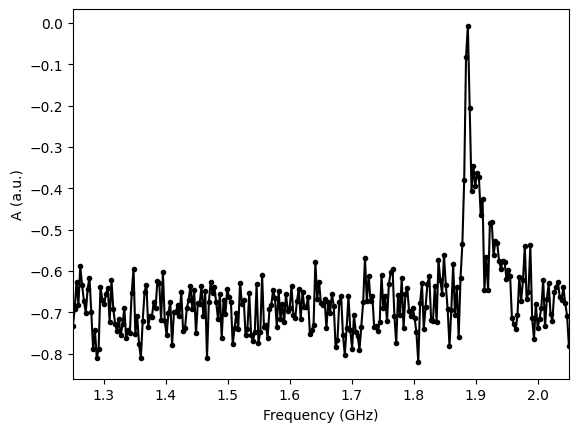

In [143]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.margins(x=0)

# plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

## Two-tone vs flux
Fine two tone sweep to find half-flux

In [144]:
from tqdm import tqdm 
import sys

In [174]:
q1_set_current = 5.9e-3
dc_q1.ramp_current(q1_set_current, 1e-6, 0)

In [175]:
start, stop = np.array(q0_current_range)*1e-3
current_sweep = np.linspace(start, stop, 11)

dc_q0.output('on')
sweep_qspec_results_q0 = []
sweep_qspec_results_q1 = []
for current in tqdm(current_sweep, file=sys.stdout):
    dc_q0.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    
    compiled_qspec = session.compile(exp_qspec_q0)
    qspec_results_q0 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")

    compiled_qspec = session.compile(exp_qspec_q1)
    qspec_results_q1 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    
    qspec_res_q0 = qspec_results_q0.get_data("qb_spec")
    qspec_freq_q0 = qspec_results_q0.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency
    sweep_qspec_results_q0.append(qspec_res_q0)
    
    
    qspec_res_q1 = qspec_results_q1.get_data("qb_spec")
    qspec_freq_q1 = qspec_results_q1.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency
    sweep_qspec_results_q1.append(qspec_res_q1)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s][2024.08.02 12:27:12.024] INFO    Starting LabOne Q Compiler run...
[2024.08.02 12:27:12.049] INFO    Schedule completed. [0.018 s]
[2024.08.02 12:27:12.200] INFO    Code generation completed for all AWGs. [0.150 s]
[2024.08.02 12:27:12.204] INFO    Completed compilation step 1 of 1. [0.173 s]
[2024.08.02 12:27:12.211] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 12:27:12.214] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 12:27:12.216] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 12:27:12.218] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 12:27:12.220] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 12:27:12.221] INFO     ─────────────────────

Text(0.5, 1.0, 'mag')

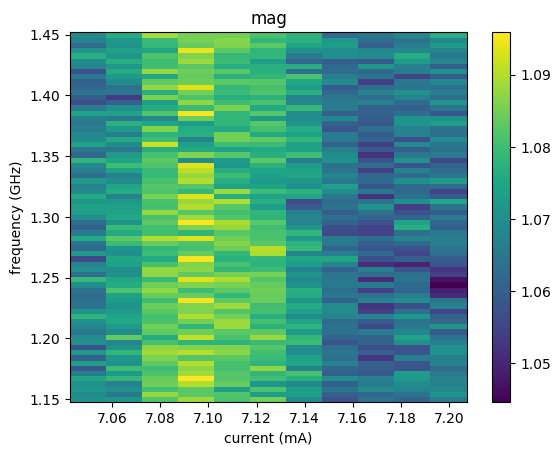

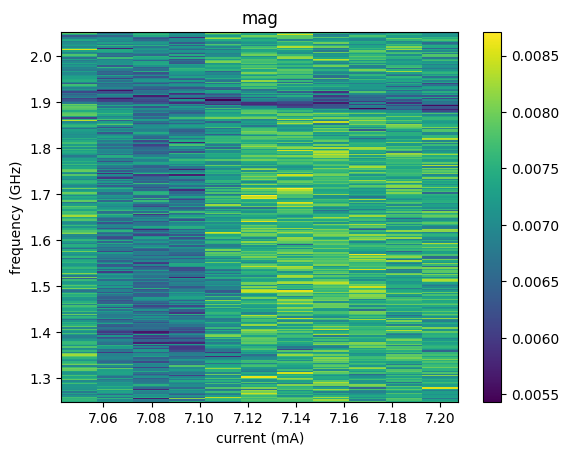

In [176]:
plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q0/1e9, np.abs(sweep_qspec_results_q0).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q1/1e9, np.abs(sweep_qspec_results_q1).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

In [82]:
def norm(results, thresh_low = -2, thresh_high = 2):
    angle_data = np.abs(np.unwrap(np.angle(results).T))
    norm = np.array(angle_data) - np.nanmedian(angle_data, axis=0)
    norm[(norm > thresh_high) | (norm < thresh_low)] = np.nan
    return norm

In [178]:
norm_0 = norm(sweep_qspec_results_q0)
norm_1 = norm(sweep_qspec_results_q1)

Text(0.5, 1.0, 'Q1 01 vs Q0 flux: phase')

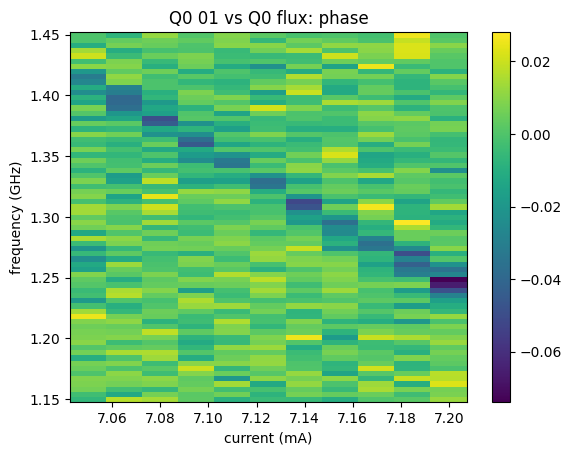

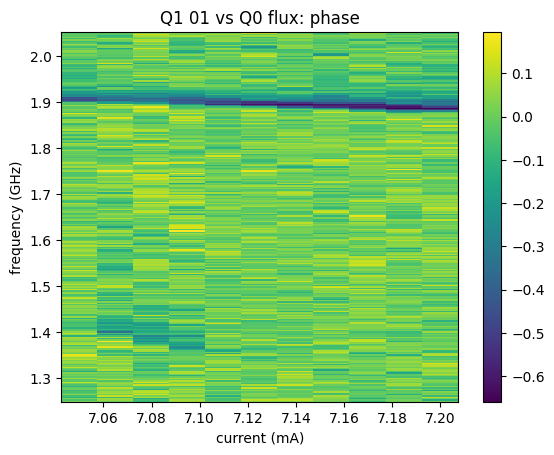

In [179]:
plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q0/1e9, norm_0)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q0 flux: phase')

plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q1/1e9, norm_1)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q0 flux: phase')

In [347]:
from scipy import stats

def find_peaks(norm, qspec_freq, current_sweep, qubit_label, flux_label, peak_function = np.nanargmin, start=None, end=None):
    peaks_loc = peak_function(norm, axis=0)
    peak_freq = (qspec_freq/1e9)[peaks_loc]    
    slope, intercept, r_value, p_value, std_err = stats.linregress((current_sweep)[start:end],peak_freq[start:end])    

    plt.figure()
    plt.plot((current_sweep)[start:end], peak_freq[start:end], label='01 transition')
    plt.ylabel('frequency (GHz)')
    plt.xlabel('current (mA)')
    plt.title(f'Q{qubit_label} 01 transition vs Q{flux_label} flux')
    plt.margins(x=0)
    plt.plot((current_sweep)[start:end],
             slope*(current_sweep)[start:end] + intercept,
             ls='--',
             alpha=0.4,
             color='k',
             label=f'linear fit: {np.round(slope, 4)} GHz/mA')    
    plt.legend()

    return slope, intercept

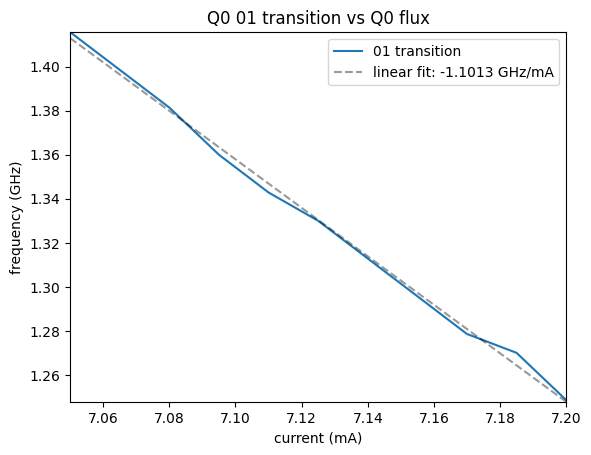

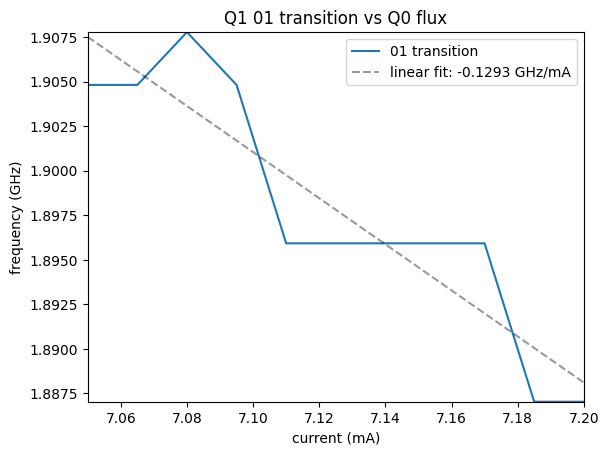

In [185]:
slope_00, offset_00 = find_peaks(norm_0, 
                      qspec_freq_q0, 
                      current_sweep, 
                      qubit_label='0', 
                      flux_label='0', 
                      peak_function = np.nanargmin
                     )

slope_01, offset_01 = find_peaks(norm_1, 
                      qspec_freq_q1, 
                      current_sweep, 
                      qubit_label='1', 
                      flux_label='0', 
                      peak_function = np.nanargmin
                     )

### Tune Q1's flux

In [186]:
q0_set_current = 7.15e-3
dc_q0.ramp_current(q0_set_current, 1e-6, 0)

In [187]:
start, stop = np.array(q1_current_range)*1e-3
current_sweep = np.linspace(start, stop, 11)

dc_q1.output('on')
sweep_qspec_results_q0 = []
sweep_qspec_results_q1 = []
for current in tqdm(current_sweep, file=sys.stdout):
    dc_q1.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    
    compiled_qspec = session.compile(exp_qspec_q0)
    qspec_results_q0 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")

    compiled_qspec = session.compile(exp_qspec_q1)
    qspec_results_q1 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    
    qspec_res_q0 = qspec_results_q0.get_data("qb_spec")
    qspec_freq_q0 = qspec_results_q0.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency
    sweep_qspec_results_q0.append(qspec_res_q0)
    
    
    qspec_res_q1 = qspec_results_q1.get_data("qb_spec")
    qspec_freq_q1 = qspec_results_q1.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency
    sweep_qspec_results_q1.append(qspec_res_q1)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s][2024.08.02 12:29:23.174] INFO    Starting LabOne Q Compiler run...
[2024.08.02 12:29:23.192] INFO    Schedule completed. [0.013 s]
[2024.08.02 12:29:23.362] INFO    Code generation completed for all AWGs. [0.167 s]
[2024.08.02 12:29:23.367] INFO    Completed compilation step 1 of 1. [0.189 s]
[2024.08.02 12:29:23.379] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 12:29:23.383] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 12:29:23.386] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 12:29:23.388] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 12:29:23.389] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 12:29:23.390] INFO     ─────────────────────

Text(0.5, 1.0, 'mag')

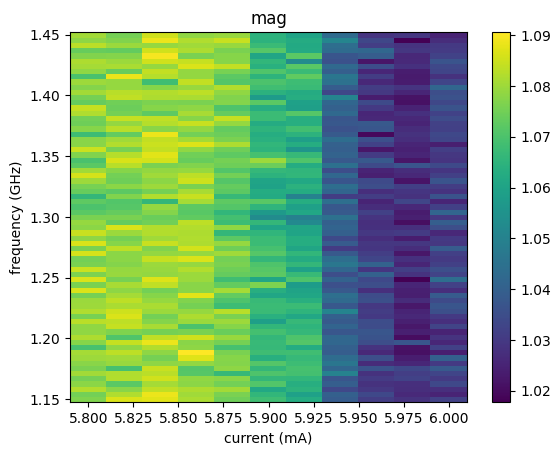

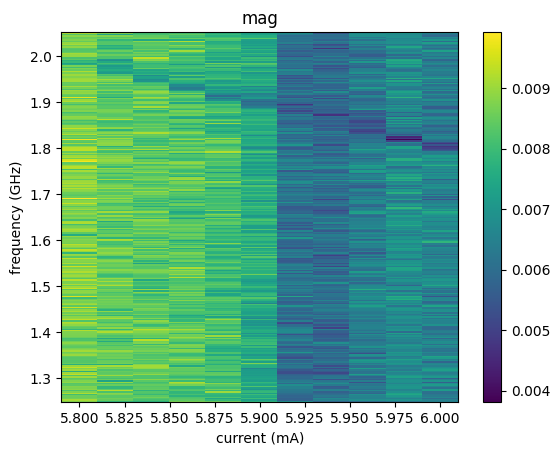

In [188]:
plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q0/1e9, np.abs(sweep_qspec_results_q0).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q1/1e9, np.abs(sweep_qspec_results_q1).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

In [189]:
norm_0 = norm(sweep_qspec_results_q0)
norm_1 = norm(sweep_qspec_results_q1)

Text(0.5, 1.0, 'Q1 01 vs Q1 flux: phase')

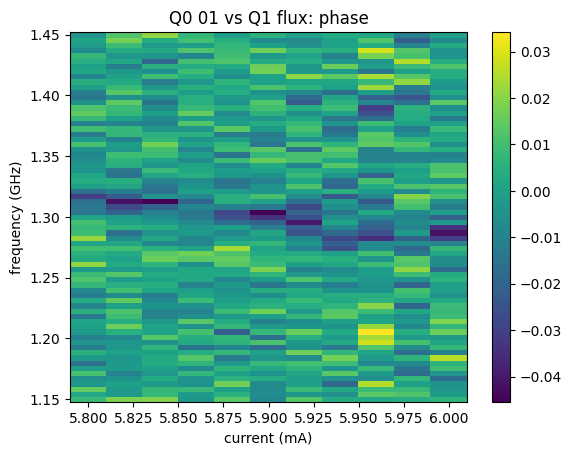

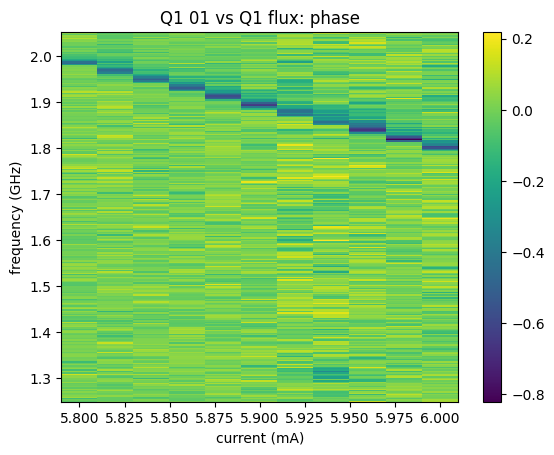

In [190]:
plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q0/1e9, norm_0)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q1 flux: phase')

plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q1/1e9, norm_1)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q1 flux: phase')

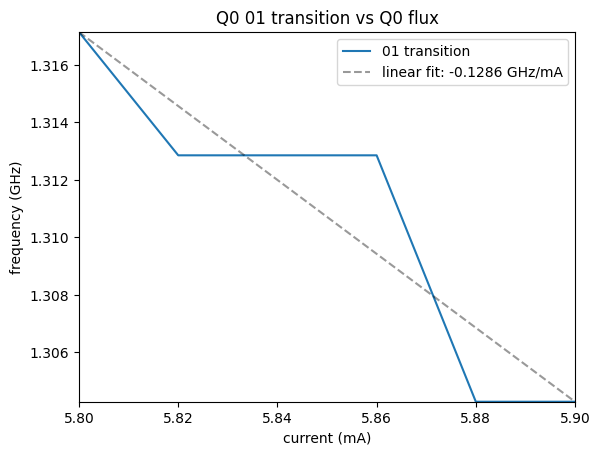

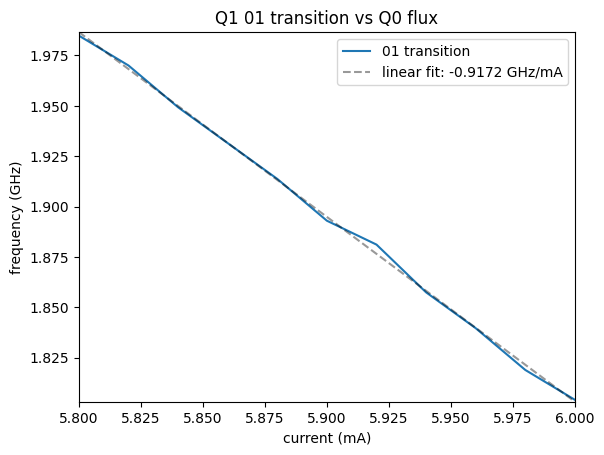

In [191]:
slope_10, offset_10 = find_peaks(norm_0, 
                      qspec_freq_q0, 
                      current_sweep, 
                      qubit_label='0', 
                      flux_label='0', 
                      peak_function = np.nanargmin,
                      end=6,
                     )

slope_11, offset_11 = find_peaks(norm_1, 
                      qspec_freq_q1, 
                      current_sweep, 
                      qubit_label='1', 
                      flux_label='0', 
                      peak_function = np.nanargmin
                     )

Text(0.5, 1.0, 'phase')

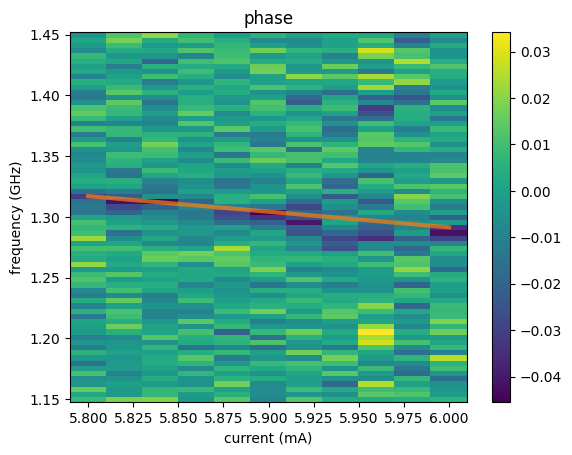

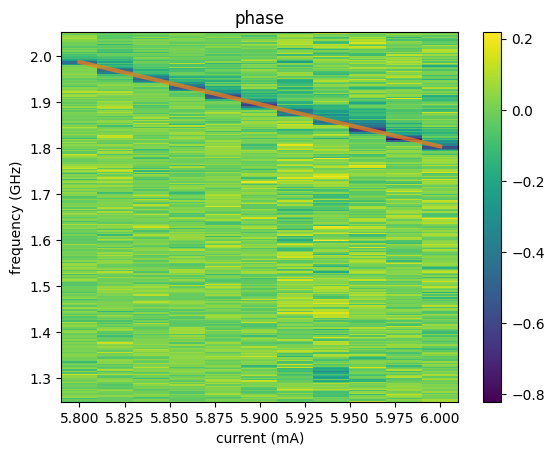

In [195]:
alpha = 0.7
lw = 3

plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q0/1e9, norm_0)
plt.plot( current_sweep*1e3, slope_10*(current_sweep*1e3) + offset_10, color='tab:orange', alpha=alpha, lw=lw)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')

plt.figure()
plt.pcolor( current_sweep*1e3,qspec_freq_q1/1e9, norm_1)
plt.plot( current_sweep*1e3, slope_11*(current_sweep*1e3) + offset_11, color='tab:orange', alpha=alpha, lw=lw)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')

In [203]:
flux_xtalk_matrix = np.array([[slope_00, slope_01], [slope_10, slope_11]])

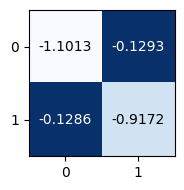

In [219]:
fig, ax = plt.subplots(figsize=(2,2))
im = ax.imshow(flux_xtalk_matrix, cmap='Blues')

ax.set_xticks(np.arange(flux_xtalk_matrix.shape[0]))
ax.set_yticks(np.arange(flux_xtalk_matrix.shape[1]))

# Loop over data dimensions and create text annotations.
for i in range(flux_xtalk_matrix.shape[0]):
    for j in range(flux_xtalk_matrix.shape[1]):
        v = np.round(flux_xtalk_matrix[i, j], 4)
        if v > -0.5:
            color='w'
        else:
            color='k'
        text = ax.text(j, i, v,
                       ha="center", va="center", color=color)
fig.tight_layout()

In [220]:
M = flux_xtalk_matrix

In [222]:
M_inv = np.linalg.inv(M)

In [223]:
M_inv

array([[-0.92321263,  0.13014451],
       [ 0.12941826, -1.10855235]])

In [226]:
np.dot(M_inv, np.array([1, 1]).T)

array([-0.79306811, -0.9791341 ])

In [247]:
center_current_q0 = 7.12e-3
center_current_q1 = 5.9e-3

In [249]:
nI = 11
dI = np.linspace(-0.1, 0.1, nI)*1e-3
target_fluxes = np.vstack((dI, np.zeros(nI)))  # small tuning range on q0
dI_c = np.dot(M_inv, target_fluxes)

In [250]:
center_currents = np.vstack((np.ones(nI)*center_current_q0, np.ones(nI)*center_current_q1))

In [251]:
current_sweep = dI_c + center_currents

In [252]:
current_sweep

array([[0.00721232, 0.00719386, 0.00717539, 0.00715693, 0.00713846,
        0.00712   , 0.00710154, 0.00708307, 0.00706461, 0.00704614,
        0.00702768],
       [0.00588706, 0.00588965, 0.00589223, 0.00589482, 0.00589741,
        0.0059    , 0.00590259, 0.00590518, 0.00590777, 0.00591035,
        0.00591294]])

### Test independent flux control, drive q0 flux

In [255]:
dc_q0.output('on')
dc_q1.output('on')
dc_q1.ramp_current(center_current_q1, 1e-6, 0)
dc_q0.ramp_current(center_current_q0, 1e-6, 0)

In [256]:
sweep_qspec_results_q0 = []
sweep_qspec_results_q1 = []
for (I0, I1) in tqdm(current_sweep.T, file=sys.stdout):
    dc_q0.ramp_current(I0, 1e-6, 0)
    dc_q1.ramp_current(I1, 1e-6, 0)
    time.sleep(0.5)

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    
    compiled_qspec = session.compile(exp_qspec_q0)
    qspec_results_q0 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")

    compiled_qspec = session.compile(exp_qspec_q1)
    qspec_results_q1 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    
    qspec_res_q0 = qspec_results_q0.get_data("qb_spec")
    qspec_freq_q0 = qspec_results_q0.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency
    sweep_qspec_results_q0.append(qspec_res_q0)
    
    
    qspec_res_q1 = qspec_results_q1.get_data("qb_spec")
    qspec_freq_q1 = qspec_results_q1.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency
    sweep_qspec_results_q1.append(qspec_res_q1)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s][2024.08.02 14:47:09.700] INFO    Starting LabOne Q Compiler run...
[2024.08.02 14:47:09.730] INFO    Schedule completed. [0.025 s]
[2024.08.02 14:47:09.860] INFO    Code generation completed for all AWGs. [0.127 s]
[2024.08.02 14:47:09.863] INFO    Completed compilation step 1 of 1. [0.159 s]
[2024.08.02 14:47:09.876] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 14:47:09.880] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 14:47:09.881] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 14:47:09.883] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 14:47:09.885] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 14:47:09.886] INFO     ─────────────────────

In [261]:
np.abs(np.array(sweep_qspec_results_q0).T).shape

(71, 11)

In [262]:
current_sweep.shape

(2, 11)

In [263]:
plot_curr = (dI + center_current_q0)*1e3

Text(0.5, 1.0, 'mag')

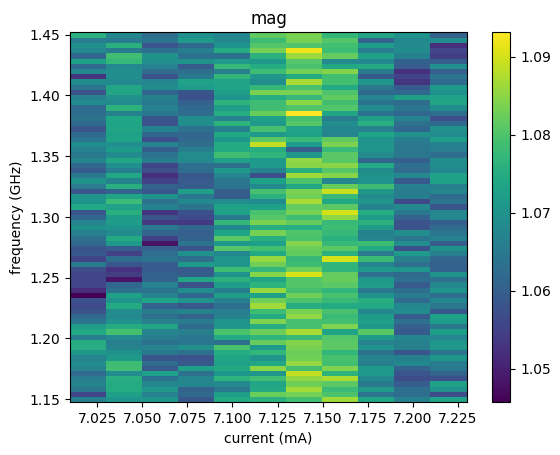

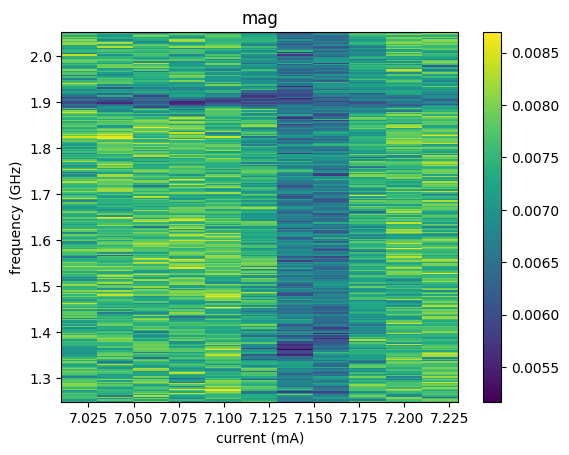

In [264]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, np.abs(sweep_qspec_results_q0).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, np.abs(sweep_qspec_results_q1).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

In [265]:
norm_0 = norm(sweep_qspec_results_q0)
norm_1 = norm(sweep_qspec_results_q1)

Text(0.5, 1.0, 'Q1 01 vs Q0 flux: phase')

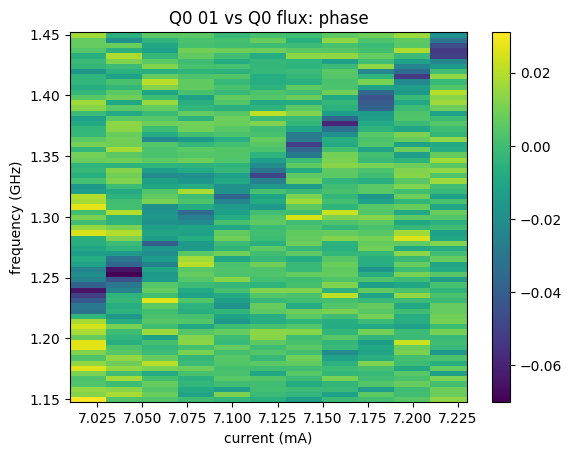

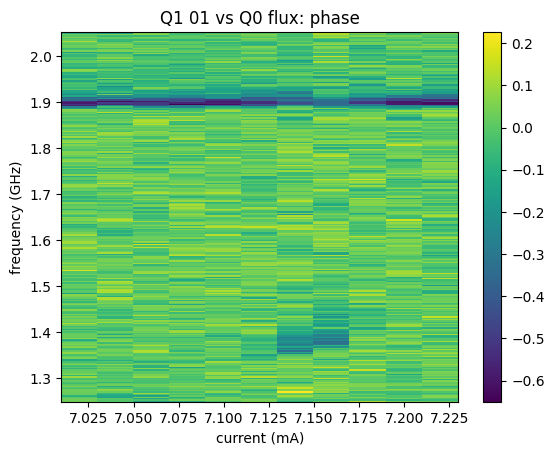

In [266]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, norm_0)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q0 flux: phase')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, norm_1)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q0 flux: phase')

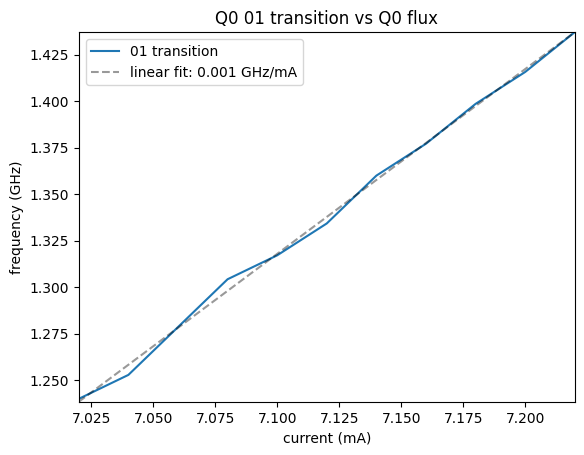

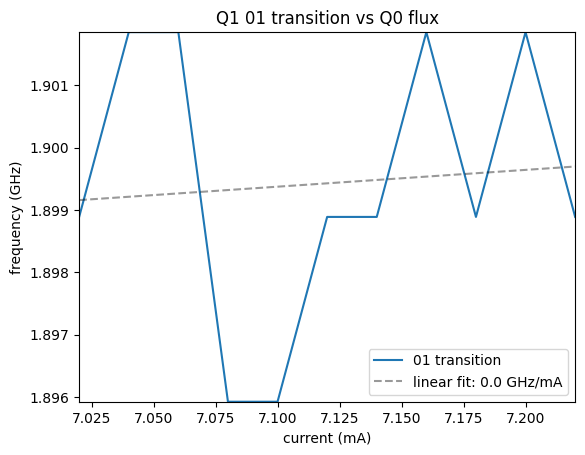

In [280]:
slope_00, offset_00 = find_peaks(norm_0, 
                      qspec_freq_q0, 
                      plot_curr, 
                      qubit_label='0', 
                      flux_label='0', 
                      peak_function = np.nanargmin
                     )

slope_01, offset_01 = find_peaks(norm_1, 
                      qspec_freq_q1, 
                      plot_curr, 
                      qubit_label='1', 
                      flux_label='0', 
                      peak_function = np.nanargmin
                     )

In [281]:
print(f'{np.round(np.abs(slope_01/slope_00)*100, 5)} % crosstalk with correction')

0.27112 % crosstalk with correction


Text(0.5, 1.0, 'Q1 01 vs Q0 flux: phase')

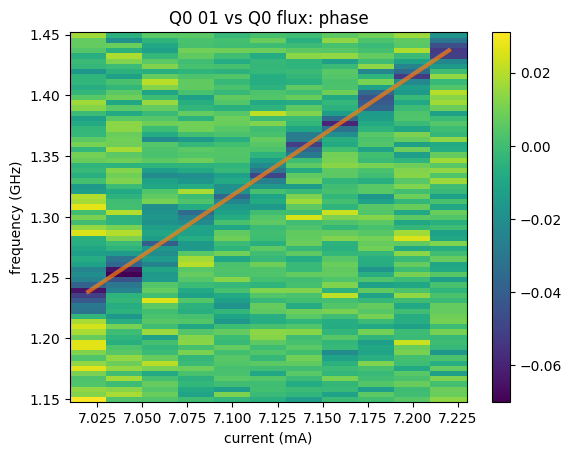

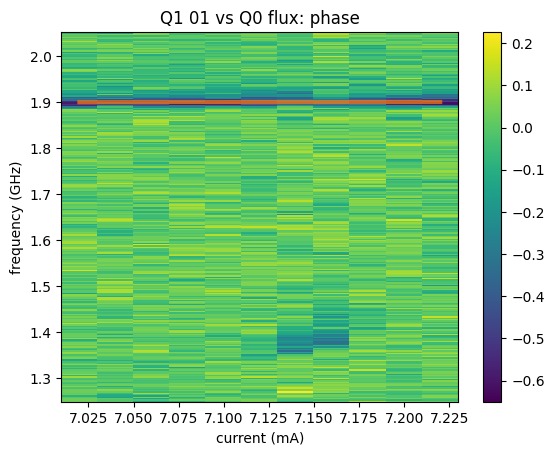

In [294]:
alpha = 0.7
lw = 3

plt.figure()
plt.pcolor( plot_curr,qspec_freq_q0/1e9, norm_0)
plt.plot( plot_curr, slope_00*(plot_curr*1e3) + offset_00, color='tab:orange', alpha=alpha, lw=lw)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q0 flux: phase')

plt.figure()
plt.pcolor( plot_curr,qspec_freq_q1/1e9, norm_1)
plt.plot( plot_curr, slope_01*(plot_curr*1e3) + offset_01, color='tab:orange', alpha=alpha, lw=lw)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q0 flux: phase')

### Test independent flux control, drive q1 flux

In [317]:
nI = 31
dI = np.linspace(-0.1, 0.1, nI)*1e-3
target_fluxes = np.vstack((np.zeros(nI), dI))  # small tuning range on q1
dI_c = np.dot(M_inv, target_fluxes)

In [318]:
center_currents = np.vstack((np.ones(nI)*center_current_q0, np.ones(nI)*center_current_q1))

In [319]:
current_sweep = dI_c + center_currents

In [320]:
current_sweep

array([[0.00710699, 0.00710785, 0.00710872, 0.00710959, 0.00711046,
        0.00711132, 0.00711219, 0.00711306, 0.00711393, 0.00711479,
        0.00711566, 0.00711653, 0.0071174 , 0.00711826, 0.00711913,
        0.00712   , 0.00712087, 0.00712174, 0.0071226 , 0.00712347,
        0.00712434, 0.00712521, 0.00712607, 0.00712694, 0.00712781,
        0.00712868, 0.00712954, 0.00713041, 0.00713128, 0.00713215,
        0.00713301],
       [0.00601086, 0.00600346, 0.00599607, 0.00598868, 0.00598129,
        0.0059739 , 0.00596651, 0.00595912, 0.00595173, 0.00594434,
        0.00593695, 0.00592956, 0.00592217, 0.00591478, 0.00590739,
        0.0059    , 0.00589261, 0.00588522, 0.00587783, 0.00587044,
        0.00586305, 0.00585566, 0.00584827, 0.00584088, 0.00583349,
        0.0058261 , 0.00581871, 0.00581132, 0.00580393, 0.00579654,
        0.00578914]])

In [321]:
dc_q0.output('on')
dc_q1.output('on')
dc_q1.ramp_current(center_current_q1, 1e-6, 0)
dc_q0.ramp_current(center_current_q0, 1e-6, 0)

In [ ]:
sweep_qspec_results_q0 = []
sweep_qspec_results_q1 = []
for (I0, I1) in tqdm(current_sweep.T, file=sys.stdout):
    dc_q0.ramp_current(I0, 1e-6, 0)
    dc_q1.ramp_current(I1, 1e-6, 0)
    time.sleep(0.5)

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    
    compiled_qspec = session.compile(exp_qspec_q0)
    qspec_results_q0 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")

    compiled_qspec = session.compile(exp_qspec_q1)
    qspec_results_q1 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    
    qspec_res_q0 = qspec_results_q0.get_data("qb_spec")
    qspec_freq_q0 = qspec_results_q0.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency
    sweep_qspec_results_q0.append(qspec_res_q0)
    
    
    qspec_res_q1 = qspec_results_q1.get_data("qb_spec")
    qspec_freq_q1 = qspec_results_q1.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency
    sweep_qspec_results_q1.append(qspec_res_q1)

  0%|                                                                                           | 0/31 [00:00<?, ?it/s][2024.08.02 15:14:05.126] INFO    Starting LabOne Q Compiler run...
[2024.08.02 15:14:05.158] INFO    Schedule completed. [0.028 s]
[2024.08.02 15:14:05.285] INFO    Code generation completed for all AWGs. [0.124 s]
[2024.08.02 15:14:05.288] INFO    Completed compilation step 1 of 1. [0.158 s]
[2024.08.02 15:14:05.292] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 15:14:05.293] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 15:14:05.295] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 15:14:05.298] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 15:14:05.303] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 15:14:05.305] INFO     ─────────────────────

In [331]:
plot_curr = (dI + center_current_q1)*1e3

Text(0.5, 1.0, 'mag')

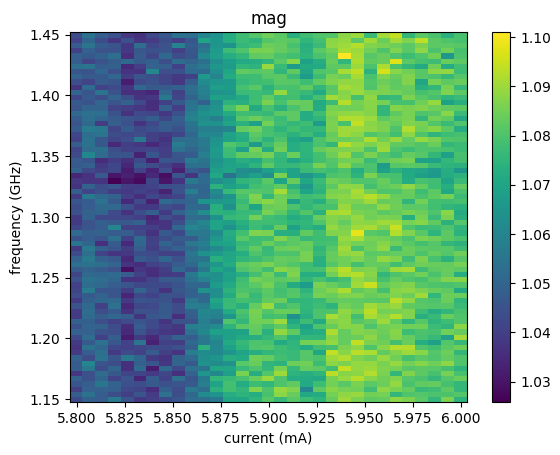

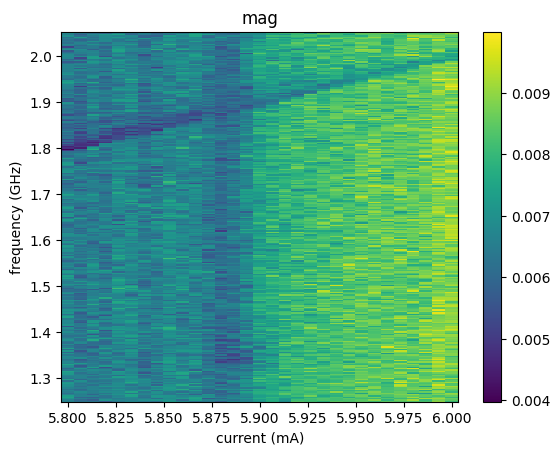

In [332]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, np.abs(sweep_qspec_results_q0).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, np.abs(sweep_qspec_results_q1).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

In [333]:
norm_0 = norm(sweep_qspec_results_q0)
norm_1 = norm(sweep_qspec_results_q1)

Text(0.5, 1.0, 'Q1 01 vs Q1 flux: phase')

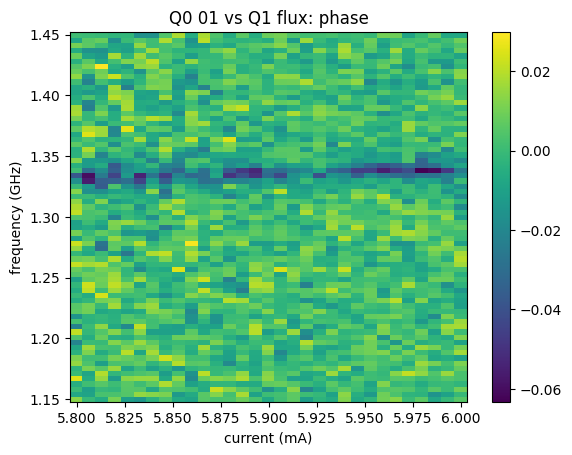

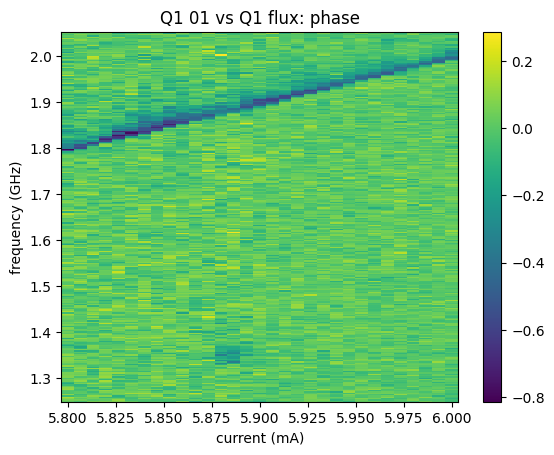

In [334]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, norm_0)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q1 flux: phase')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, norm_1)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q1 flux: phase')

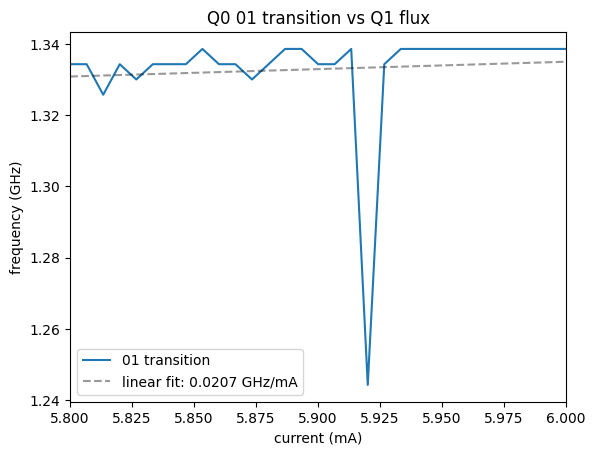

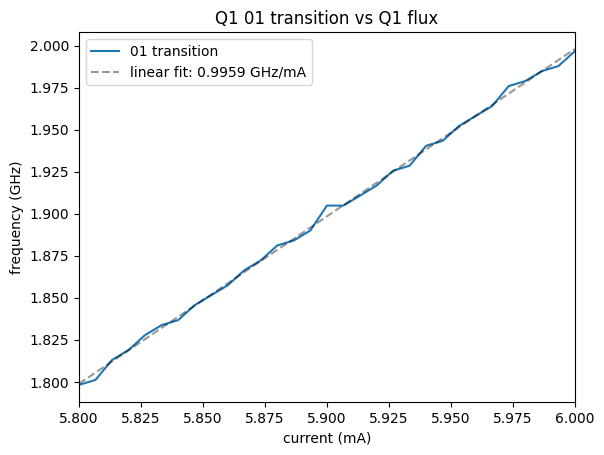

In [348]:
slope_10, offset_10 = find_peaks(norm_0, 
                      qspec_freq_q0, 
                      plot_curr, 
                      qubit_label='0', 
                      flux_label='1', 
                      peak_function = np.nanargmin
                     )

slope_11, offset_11 = find_peaks(norm_1, 
                      qspec_freq_q1, 
                      plot_curr, 
                      qubit_label='1', 
                      flux_label='1', 
                      peak_function = np.nanargmin
                     )

In [336]:
print(f'{np.round(np.abs(slope_10/slope_01)*100, 5)} % crosstalk with correction')

2.08355 % crosstalk with correction


Text(0.5, 1.0, 'Q1 01 vs Q1 flux: phase')

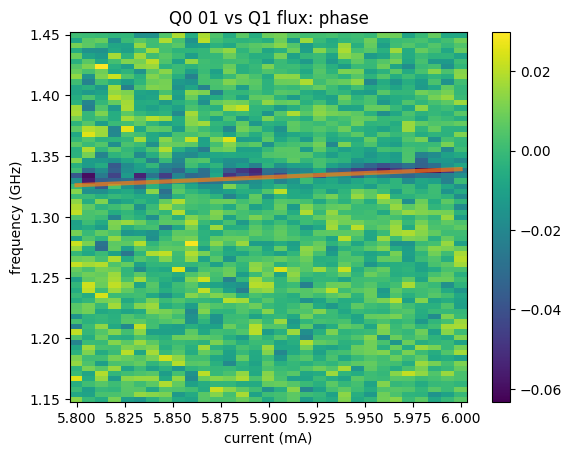

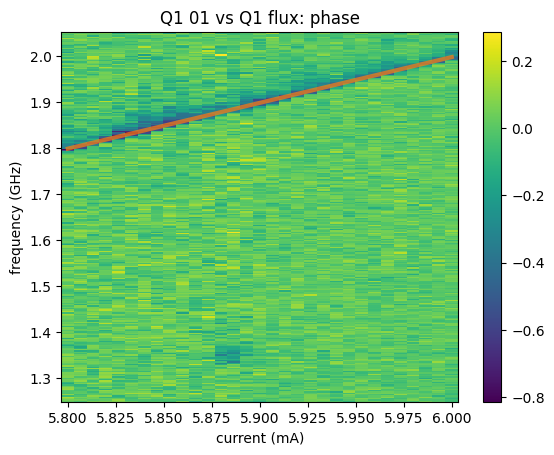

In [338]:
alpha = 0.7
lw = 3

plt.figure()
plt.pcolor( plot_curr,qspec_freq_q0/1e9, norm_0)
plt.plot( plot_curr, slope_00*(plot_curr*1e3) + offset_00, color='tab:orange', alpha=alpha, lw=lw)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q1 flux: phase')

plt.figure()
plt.pcolor( plot_curr,qspec_freq_q1/1e9, norm_1)
plt.plot( plot_curr, slope_01*(plot_curr*1e3) + offset_01, color='tab:orange', alpha=alpha, lw=lw)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q1 flux: phase')

### Tune q0 to half-flux
lower frequency qubit

#### check that q1 still has small frequency window

In [34]:
qspec_num = 51
start_freq = -80e6
stop_freq = 80e6
LF_path = False
num_averages=10
q1.parameters.resonance_frequency_ge = 1.88e9

device_setup.set_calibration(
    q1.calibration()
)

In [35]:
q1.parameters.drive_lo_frequency = q1.parameters.drive_lo_frequency

In [36]:
freq_sweep_q1 = create_drive_freq_sweep(q1, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q1 = Calibration()

if LF_path == True:
    exp_calibration_q1["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q1,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q1["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q1,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [37]:
drive_pulse = create_drive_spec_pulse(q1, amp=0.4)

readout_pulse = create_readout_pulse(q1)

#update default calibration to qubit settings
device_setup.set_calibration(
    q1.calibration()
)

exp_qspec_q1 = qubit_spectroscopy(freq_sweep_q1, drive_pulse, readout_pulse, reset_delay = q1.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec_q1.set_calibration(exp_calibration_q1)
exp_qspec_q1.set_signal_map(signal_map_default(q1))
compiled_qspec = session.compile(exp_qspec_q1)

[2024.08.02 15:58:05.683] INFO    Starting LabOne Q Compiler run...
[2024.08.02 15:58:05.696] INFO    Schedule completed. [0.009 s]
[2024.08.02 15:58:05.797] INFO    Code generation completed for all AWGs. [0.099 s]
[2024.08.02 15:58:05.802] INFO    Completed compilation step 1 of 1. [0.115 s]
[2024.08.02 15:58:05.813] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 15:58:05.817] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 15:58:05.819] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 15:58:05.821] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 15:58:05.822] INFO      device_shfqc_sg     2         22            1           1      4000  
[2024.08.02 15:58:05.823] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 15:58:05.825] INFO      TOTAL                         32 

In [38]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.02 15:58:05.837] INFO    Configuring the device setup
[2024.08.02 15:58:05.940] INFO    The device setup is configured
[2024.08.02 15:58:06.884] INFO    Starting near-time execution...
[2024.08.02 15:58:07.889] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240802T155808.json


estimated frequency 1.8576 GHz


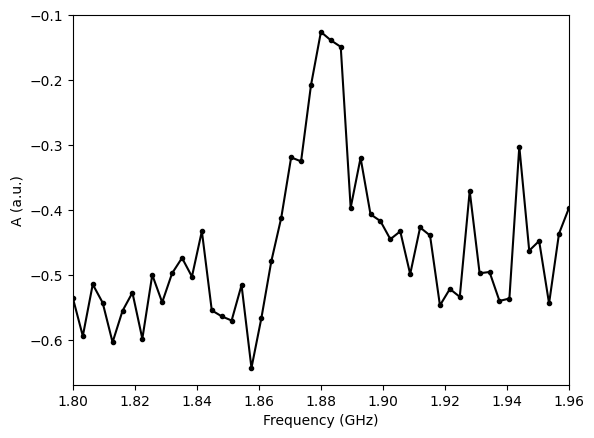

In [39]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.margins(x=0)

# plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

#### adjust two tone window

In [52]:
dc_q0.ramp_current(8e-3, 1e-6, 0)

In [121]:
qspec_num = 371
start_freq = -650e6
stop_freq = -500e6
q0.parameters.resonance_frequency_ge = 1.3e9
LF_path = False
num_averages = 11

device_setup.set_calibration(
    q0.calibration()
)

In [122]:
freq_sweep_q0 = create_drive_freq_sweep(q0, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q0 = Calibration()

if LF_path == True:
    exp_calibration_q0["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q0,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q0["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q0,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [126]:
drive_pulse = create_drive_spec_pulse(q0, amp=0.5)

readout_pulse = create_readout_pulse(q0)

#update default calibration to qubit settings
device_setup.set_calibration(
    q0.calibration()
)

exp_qspec_q0 = qubit_spectroscopy(freq_sweep_q0, drive_pulse, readout_pulse, reset_delay = q0.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec_q0.set_calibration(exp_calibration_q0)
exp_qspec_q0.set_signal_map(signal_map_default(q0))
compiled_qspec = session.compile(exp_qspec_q0)

[2024.08.02 16:21:18.477] INFO    Starting LabOne Q Compiler run...
[2024.08.02 16:21:18.915] INFO    Schedule completed. [0.434 s]
[2024.08.02 16:21:19.857] INFO    Code generation completed for all AWGs. [0.937 s]
[2024.08.02 16:21:19.862] INFO    Completed compilation step 1 of 1. [1.382 s]
[2024.08.02 16:21:19.876] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:21:19.879] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 16:21:19.881] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:21:19.882] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 16:21:19.883] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 16:21:19.885] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:21:19.887] INFO      TOTAL                         32 

In [127]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.02 16:21:19.906] INFO    Configuring the device setup
[2024.08.02 16:21:20.016] INFO    The device setup is configured
[2024.08.02 16:21:21.030] INFO    Starting near-time execution...
[2024.08.02 16:21:25.275] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240802T162125.json


estimated frequency 0.7104054054054054 GHz


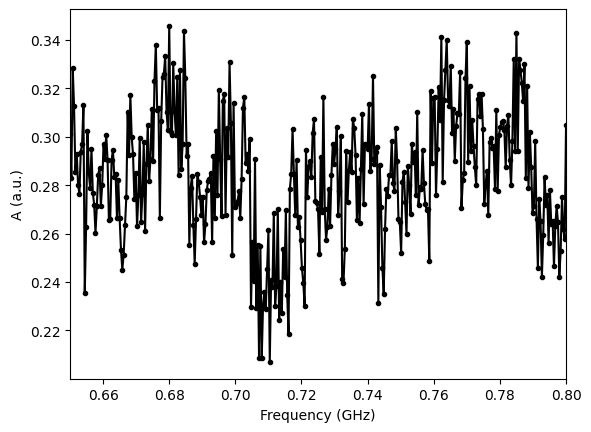

In [128]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.margins(x=0)

# plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

#### spectroscopy

In [180]:
target_cur = 7.986e-3
# target_cur = 7.98e-3
delta_single = target_cur - dc_q0.current()
delta_single

8.000000000000021e-05

In [181]:
_delta = np.dot(M_inv, np.array([delta_single, 0]).T)

In [182]:
center_current_q0 = dc_q0.current() + _delta[0]
center_current_q1 = dc_q1.current() + _delta[1]

In [183]:
print(center_current_q0, center_current_q1)

0.007979857225616371 0.005776644527677425


In [67]:
M = [[-1.1013, -0.1293], [-0.1286, -0.9172]]

In [68]:
M_inv = np.linalg.inv(M)*-1

In [95]:
nI = 21
dI = np.linspace(-0.2, 0.2, nI)*1e-3
target_fluxes = np.vstack((dI, np.zeros(nI)))  # small tuning range on q0
dI_c = np.dot(M_inv, target_fluxes)

In [96]:
center_currents = np.vstack((np.ones(nI)*center_current_q0, np.ones(nI)*center_current_q1))

In [97]:
current_sweep = dI_c + center_currents

In [98]:
current_sweep

array([[0.00782164, 0.00784011, 0.00785857, 0.00787704, 0.0078955 ,
        0.00791397, 0.00793243, 0.00795089, 0.00796936, 0.00798782,
        0.00800629, 0.00802475, 0.00804322, 0.00806168, 0.00808014,
        0.00809861, 0.00811707, 0.00813554, 0.008154  , 0.00817247,
        0.00819093],
       [0.00580162, 0.00579903, 0.00579645, 0.00579386, 0.00579127,
        0.00578868, 0.00578609, 0.0057835 , 0.00578091, 0.00577832,
        0.00577573, 0.00577315, 0.00577056, 0.00576797, 0.00576538,
        0.00576279, 0.0057602 , 0.00575761, 0.00575502, 0.00575243,
        0.00574985]])

In [150]:
center_current_q1, center_current_q0

(0.005912944340403218, 0.007027678467979536)

In [184]:
dc_q0.output('on')
dc_q1.output('on')
dc_q1.ramp_current(center_current_q1, 1e-6, 0)
dc_q0.ramp_current(center_current_q0, 1e-6, 0)

In [100]:
from tqdm import tqdm

In [130]:
sweep_qspec_results_q0 = []
sweep_qspec_results_q1 = []
for (I0, I1) in tqdm(current_sweep.T, file=sys.stdout):
    dc_q0.ramp_current(I0, 1e-6, 0)
    dc_q1.ramp_current(I1, 1e-6, 0)
    time.sleep(0.5)

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    
    compiled_qspec = session.compile(exp_qspec_q0)
    qspec_results_q0 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")

    compiled_qspec = session.compile(exp_qspec_q1)
    qspec_results_q1 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    
    qspec_res_q0 = qspec_results_q0.get_data("qb_spec")
    qspec_freq_q0 = qspec_results_q0.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency
    sweep_qspec_results_q0.append(qspec_res_q0)
    
    
    qspec_res_q1 = qspec_results_q1.get_data("qb_spec")
    qspec_freq_q1 = qspec_results_q1.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency
    sweep_qspec_results_q1.append(qspec_res_q1)

  0%|                                                                                           | 0/21 [00:00<?, ?it/s][2024.08.02 16:22:30.108] INFO    Starting LabOne Q Compiler run...
[2024.08.02 16:22:30.618] INFO    Schedule completed. [0.502 s]
[2024.08.02 16:22:31.496] INFO    Code generation completed for all AWGs. [0.875 s]
[2024.08.02 16:22:31.501] INFO    Completed compilation step 1 of 1. [1.384 s]
[2024.08.02 16:22:31.508] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:22:31.511] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 16:22:31.514] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:22:31.518] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 16:22:31.522] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 16:22:31.526] INFO     ─────────────────────

In [131]:
plot_curr = (dI + center_current_q0)*1e3

Text(0.5, 1.0, 'mag')

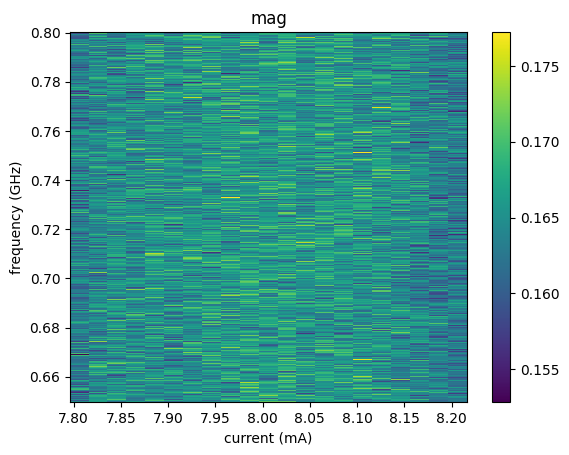

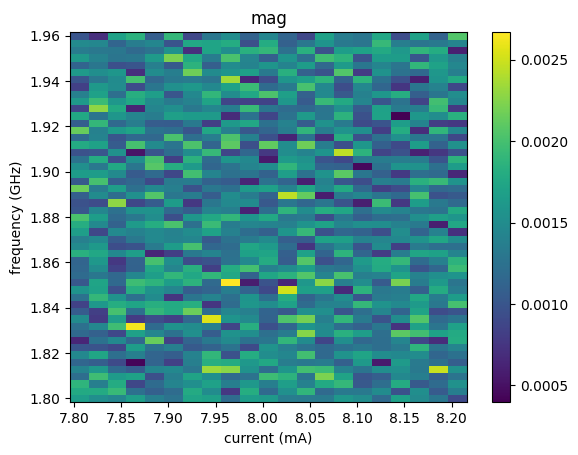

In [132]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, np.abs(sweep_qspec_results_q0).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, np.abs(sweep_qspec_results_q1).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

In [133]:
def norm(results, thresh_low = -2, thresh_high = 2):
    angle_data = np.abs(np.unwrap(np.angle(results).T))
    norm = np.array(angle_data) - np.nanmedian(angle_data, axis=0)
    norm[(norm > thresh_high) | (norm < thresh_low)] = np.nan
    return norm

In [134]:
norm_0 = norm(sweep_qspec_results_q0)
norm_1 = norm(sweep_qspec_results_q1)

Text(0.5, 1.0, 'Q1 01 vs Q0 flux: phase')

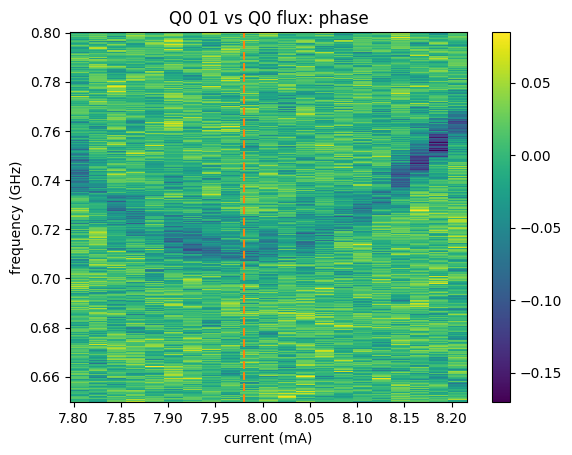

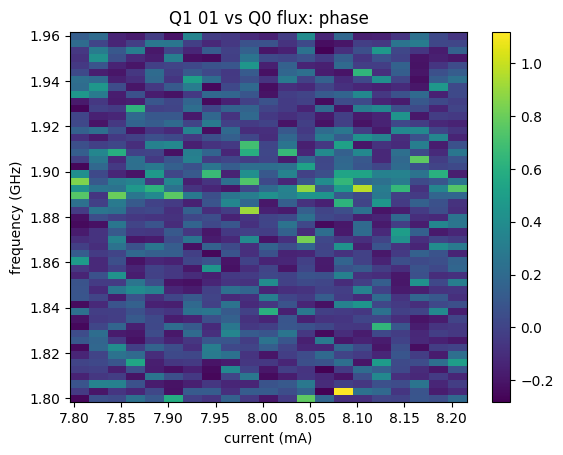

In [142]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, norm_0)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q0 flux: phase')
plt.axvline(7.98, ls='--', c='tab:orange')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, norm_1)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q0 flux: phase')

In [140]:
from scipy import stats

def find_peaks_nofit(norm, qspec_freq, current_sweep, qubit_label, flux_label, peak_function = np.nanargmin, start=None, end=None):
    peaks_loc = peak_function(norm, axis=0)
    peak_freq = (qspec_freq/1e9)[peaks_loc]    

    plt.figure()
    plt.plot((current_sweep)[start:end], peak_freq[start:end], label='01 transition')
    plt.ylabel('frequency (GHz)')
    plt.xlabel('current (mA)')
    plt.title(f'Q{qubit_label} 01 transition vs Q{flux_label} flux')
    plt.margins(x=0)

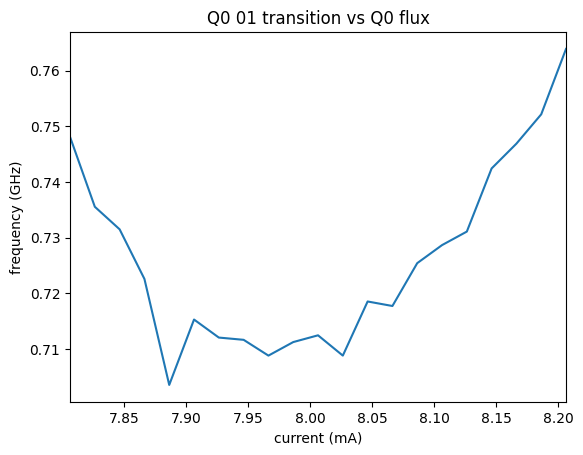

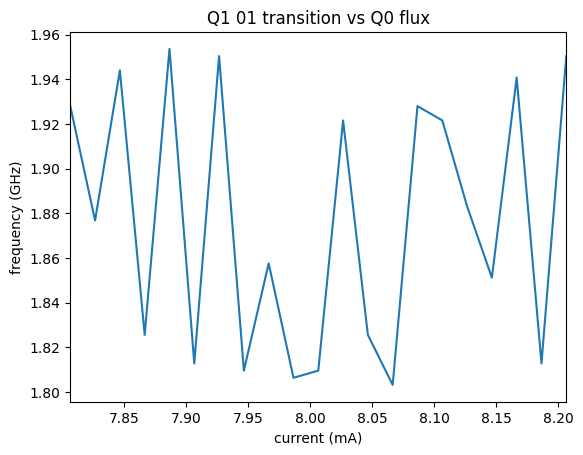

In [141]:
find_peaks_nofit(norm_0, 
                      qspec_freq_q0, 
                      plot_curr, 
                      qubit_label='0', 
                      flux_label='0', 
                      peak_function = np.nanargmin
                     )

find_peaks_nofit(norm_1, 
                      qspec_freq_q1, 
                      plot_curr, 
                      qubit_label='1', 
                      flux_label='0', 
                      peak_function = np.nanargmin
                     )

### Tune q1 to half-flux
Higher frequency qubit

#### q1 frequency window

In [190]:
qspec_num = 451
start_freq = -400e6
stop_freq = 630e6
LF_path = False
num_averages=10
q1.parameters.resonance_frequency_ge = 1.3e9
q1.parameters.drive_lo_frequency = 1.3e9

device_setup.set_calibration(
    q1.calibration()
)

In [191]:
freq_sweep_q1 = create_drive_freq_sweep(q1, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q1 = Calibration()

if LF_path == True:
    exp_calibration_q1["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q1,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q1["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q1,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [192]:
drive_pulse = create_drive_spec_pulse(q1, amp=0.4)

readout_pulse = create_readout_pulse(q1)

#update default calibration to qubit settings
device_setup.set_calibration(
    q1.calibration()
)

exp_qspec_q1 = qubit_spectroscopy(freq_sweep_q1, drive_pulse, readout_pulse, reset_delay = q1.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec_q1.set_calibration(exp_calibration_q1)
exp_qspec_q1.set_signal_map(signal_map_default(q1))
compiled_qspec = session.compile(exp_qspec_q1)

[2024.08.02 16:52:01.205] INFO    Starting LabOne Q Compiler run...
[2024.08.02 16:52:01.342] INFO    Schedule completed. [0.132 s]
[2024.08.02 16:52:02.285] INFO    Code generation completed for all AWGs. [0.941 s]
[2024.08.02 16:52:02.290] INFO    Completed compilation step 1 of 1. [1.080 s]
[2024.08.02 16:52:02.302] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:52:02.307] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 16:52:02.308] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:52:02.311] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 16:52:02.314] INFO      device_shfqc_sg     2         22            1           1      4000  
[2024.08.02 16:52:02.318] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:52:02.321] INFO      TOTAL                         32 

In [193]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.02 16:52:02.334] INFO    Configuring the device setup
[2024.08.02 16:52:02.446] INFO    The device setup is configured
[2024.08.02 16:52:03.298] INFO    Starting near-time execution...
[2024.08.02 16:52:05.730] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240802T165205.json


estimated frequency 1.8292888888888887 GHz


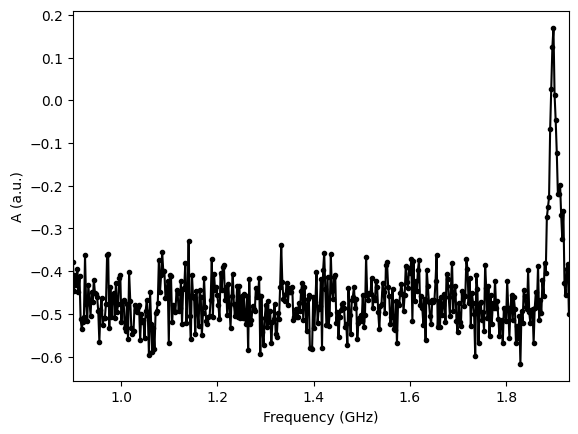

In [194]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.margins(x=0)

# plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

#### spectroscopy

In [ ]:
_delta = np.dot(M_inv, np.array([-0.1, 0]).T)

In [ ]:
center_current_q0 = 7.12e-3 + _delta[0]*1e-3
center_current_q1 = 5.9e-3 + _delta[1]*1e-3

In [ ]:
M = [[-1.1013, -0.1293], [-0.1286, -0.9172]]

In [ ]:
M_inv = np.linalg.inv(M)*-1

In [195]:
nI = 31
dI = np.linspace(0, 2, nI)*1e-3
target_fluxes = np.vstack((np.zeros(nI), dI))  # small tuning range on q0
dI_c = np.dot(M_inv, target_fluxes)

In [196]:
center_currents = np.vstack((np.ones(nI)*center_current_q0, np.ones(nI)*center_current_q1))

In [197]:
current_sweep = dI_c + center_currents

In [198]:
current_sweep

array([[0.00797986, 0.00797118, 0.0079625 , 0.00795383, 0.00794515,
        0.00793647, 0.0079278 , 0.00791912, 0.00791044, 0.00790177,
        0.00789309, 0.00788442, 0.00787574, 0.00786706, 0.00785839,
        0.00784971, 0.00784103, 0.00783236, 0.00782368, 0.007815  ,
        0.00780633, 0.00779765, 0.00778897, 0.0077803 , 0.00777162,
        0.00776294, 0.00775427, 0.00774559, 0.00773691, 0.00772824,
        0.00771956],
       [0.00577664, 0.00585055, 0.00592445, 0.00599835, 0.00607225,
        0.00614615, 0.00622005, 0.00629396, 0.00636786, 0.00644176,
        0.00651566, 0.00658956, 0.00666346, 0.00673736, 0.00681127,
        0.00688517, 0.00695907, 0.00703297, 0.00710687, 0.00718077,
        0.00725467, 0.00732858, 0.00740248, 0.00747638, 0.00755028,
        0.00762418, 0.00769808, 0.00777199, 0.00784589, 0.00791979,
        0.00799369]])

In [149]:
dc_q0.output('on')
dc_q1.output('on')
dc_q1.ramp_current(center_current_q1, 1e-6, 0)
dc_q0.ramp_current(center_current_q0, 1e-6, 0)

In [100]:
from tqdm import tqdm

In [199]:
sweep_qspec_results_q0 = []
sweep_qspec_results_q1 = []
for (I0, I1) in tqdm(current_sweep.T, file=sys.stdout):
    dc_q0.ramp_current(I0, 1e-6, 0)
    dc_q1.ramp_current(I1, 1e-6, 0)
    time.sleep(0.5)

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    
    compiled_qspec = session.compile(exp_qspec_q0)
    qspec_results_q0 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")

    compiled_qspec = session.compile(exp_qspec_q1)
    qspec_results_q1 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    
    qspec_res_q0 = qspec_results_q0.get_data("qb_spec")
    qspec_freq_q0 = qspec_results_q0.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency
    sweep_qspec_results_q0.append(qspec_res_q0)
    
    
    qspec_res_q1 = qspec_results_q1.get_data("qb_spec")
    qspec_freq_q1 = qspec_results_q1.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency
    sweep_qspec_results_q1.append(qspec_res_q1)

  0%|                                                                                           | 0/31 [00:00<?, ?it/s][2024.08.02 16:54:20.265] INFO    Starting LabOne Q Compiler run...
[2024.08.02 16:54:20.357] INFO    Schedule completed. [0.088 s]
[2024.08.02 16:54:20.991] INFO    Code generation completed for all AWGs. [0.630 s]
[2024.08.02 16:54:20.993] INFO    Completed compilation step 1 of 1. [0.725 s]
[2024.08.02 16:54:20.996] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:54:20.999] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 16:54:21.000] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 16:54:21.003] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 16:54:21.005] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 16:54:21.007] INFO     ─────────────────────

In [212]:
plot_curr = (dI + center_current_q1)*1e3

Text(0.5, 1.0, 'mag')

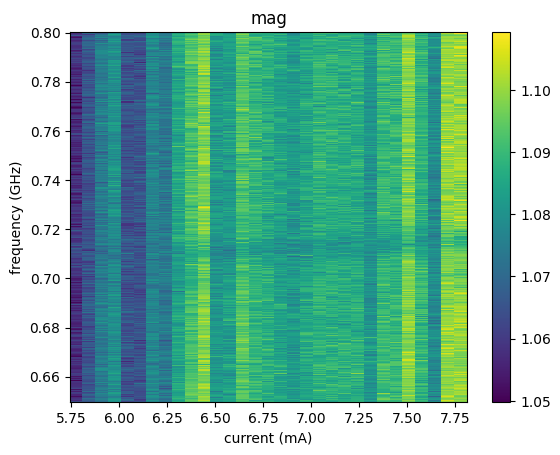

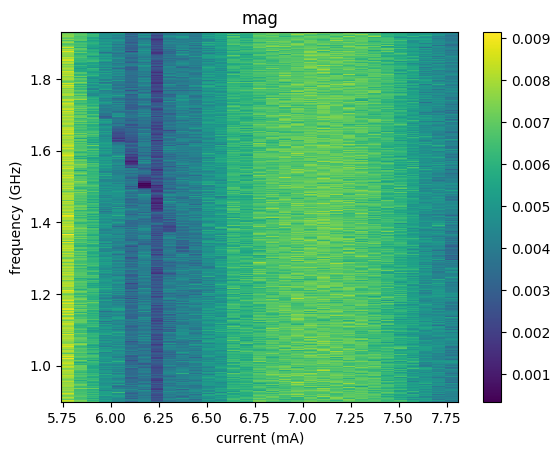

In [213]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, np.abs(sweep_qspec_results_q0).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, np.abs(sweep_qspec_results_q1).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

In [214]:
def norm(results, thresh_low = -2, thresh_high = 2):
    angle_data = np.abs(np.unwrap(np.angle(results).T))
    norm = np.array(angle_data) - np.nanmedian(angle_data, axis=0)
    norm[(norm > thresh_high) | (norm < thresh_low)] = np.nan
    return norm

In [215]:
norm_0 = norm(sweep_qspec_results_q0)
norm_1 = norm(sweep_qspec_results_q1)

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_131596\2214787481.py:13: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


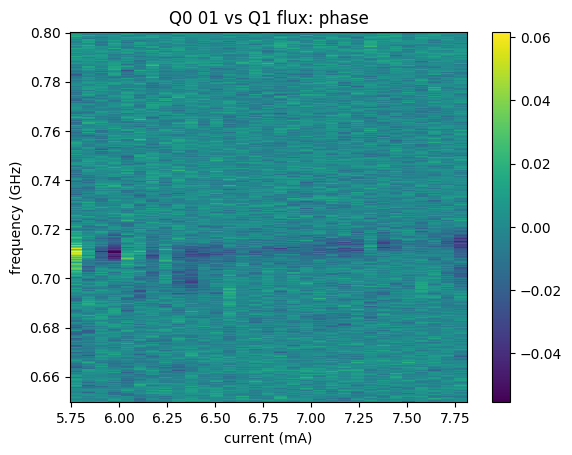

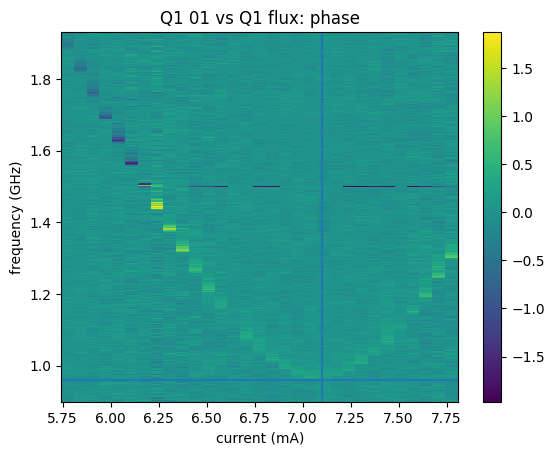

In [240]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, norm_0)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q1 flux: phase')
# plt.axvline(7.98, ls='--', c='tab:orange')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, norm_1)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q1 flux: phase')
plt.axvline(7.1)
plt.axhline(0.96)

In [235]:
target_cur = 7.20e-3
# target_cur = 7.1e-3
delta_single = target_cur - dc_q1.current()
delta_single

-0.0007930000000000003

In [236]:
_delta = np.dot(M_inv, np.array([0, delta_single]).T)

In [237]:
center_current_q0 = dc_q0.current() + _delta[0]
center_current_q1 = dc_q1.current() + _delta[1]

In [238]:
print(center_current_q0, center_current_q1)

0.007822207359938563 0.007113941488783145


In [239]:
dc_q1.ramp_current(center_current_q1, 1e-6, 0)
dc_q0.ramp_current(center_current_q0, 1e-6, 0)

# Coupler g

#### q1 small frequency window

In [241]:
qspec_num = 151
start_freq = -80e6
stop_freq = 80e6
LF_path = False
q1.parameters.resonance_frequency_ge = 0.96e9

device_setup.set_calibration(
    q1.calibration()
)

In [242]:
freq_sweep_q1 = create_drive_freq_sweep(q1, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q1 = Calibration()

if LF_path == True:
    exp_calibration_q1["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q1,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q1["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q1,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [243]:
drive_pulse = create_drive_spec_pulse(q1, amp=0.4)

readout_pulse = create_readout_pulse(q1)

#update default calibration to qubit settings
device_setup.set_calibration(
    q1.calibration()
)

exp_qspec_q1 = qubit_spectroscopy(freq_sweep_q1, drive_pulse, readout_pulse, reset_delay = q1.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec_q1.set_calibration(exp_calibration_q1)
exp_qspec_q1.set_signal_map(signal_map_default(q1))
compiled_qspec = session.compile(exp_qspec_q1)

[2024.08.02 17:15:35.114] INFO    Starting LabOne Q Compiler run...
[2024.08.02 17:15:35.157] INFO    Schedule completed. [0.037 s]
[2024.08.02 17:15:35.462] INFO    Code generation completed for all AWGs. [0.303 s]
[2024.08.02 17:15:35.465] INFO    Completed compilation step 1 of 1. [0.345 s]
[2024.08.02 17:15:35.469] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 17:15:35.470] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 17:15:35.471] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 17:15:35.473] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 17:15:35.476] INFO      device_shfqc_sg     2         22            1           1      4000  
[2024.08.02 17:15:35.481] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 17:15:35.482] INFO      TOTAL                         32 

In [244]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.02 17:15:35.499] INFO    Configuring the device setup
[2024.08.02 17:15:35.616] INFO    The device setup is configured
[2024.08.02 17:15:36.630] INFO    Starting near-time execution...
[2024.08.02 17:15:38.022] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240802T171538.json


estimated frequency 0.9770666666666667 GHz


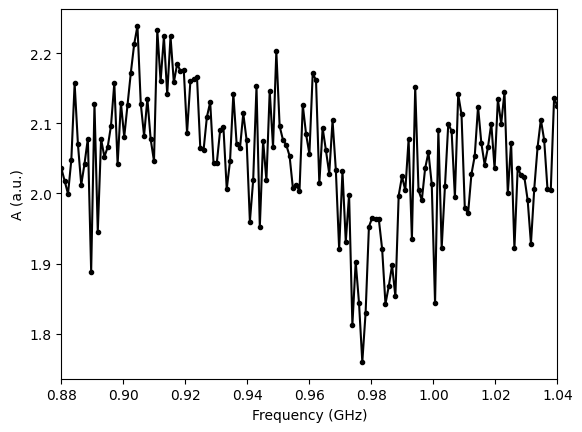

In [245]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.margins(x=0)

# plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

#### adjust two tone window

In [354]:
nI = 3
dI = np.linspace(8.3e-3 - center_current_q0, 8.5e-3 - center_current_q0, nI)
target_fluxes = np.vstack((dI, np.zeros(nI)))  # small tuning range on q0
dI_c = np.dot(M_inv, target_fluxes)

In [355]:
center_currents = np.vstack((np.ones(nI)*center_current_q0, np.ones(nI)*center_current_q1))

In [356]:
current_sweep = dI_c + center_currents

In [357]:
current_sweep

array([[0.00826331, 0.00835563, 0.00844796],
       [0.00705209, 0.00703915, 0.00702621]])

In [358]:
dc_q0.ramp_current(0.00826331, 1e-6, 0)
dc_q1.ramp_current(0.00705209, 1e-6, 0)

In [359]:
qspec_num = 471
start_freq = 200e6
stop_freq = 350e6
q0.parameters.resonance_frequency_ge = 0.71e9
LF_path = False

device_setup.set_calibration(
    q0.calibration()
)

In [360]:
freq_sweep_q0 = create_drive_freq_sweep(q0, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q0 = Calibration()

if LF_path == True:
    exp_calibration_q0["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q0,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q0["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q0,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [361]:
drive_pulse = create_drive_spec_pulse(q0, amp=0.3)

readout_pulse = create_readout_pulse(q0)

#update default calibration to qubit settings
device_setup.set_calibration(
    q0.calibration()
)

exp_qspec_q0 = qubit_spectroscopy(freq_sweep_q0, drive_pulse, readout_pulse, reset_delay = q0.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec_q0.set_calibration(exp_calibration_q0)
exp_qspec_q0.set_signal_map(signal_map_default(q0))
compiled_qspec = session.compile(exp_qspec_q0)

[2024.08.02 18:31:12.502] INFO    Starting LabOne Q Compiler run...
[2024.08.02 18:31:12.619] INFO    Schedule completed. [0.114 s]
[2024.08.02 18:31:13.735] INFO    Code generation completed for all AWGs. [1.113 s]
[2024.08.02 18:31:13.738] INFO    Completed compilation step 1 of 1. [1.233 s]
[2024.08.02 18:31:13.749] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 18:31:13.753] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 18:31:13.757] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 18:31:13.759] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 18:31:13.762] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 18:31:13.764] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 18:31:13.766] INFO      TOTAL                         32 

In [362]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.08.02 18:31:13.778] INFO    Configuring the device setup
[2024.08.02 18:31:13.894] INFO    The device setup is configured
[2024.08.02 18:31:14.817] INFO    Starting near-time execution...
[2024.08.02 18:31:17.926] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240802T183118.json


estimated frequency 0.9808510638297873 GHz


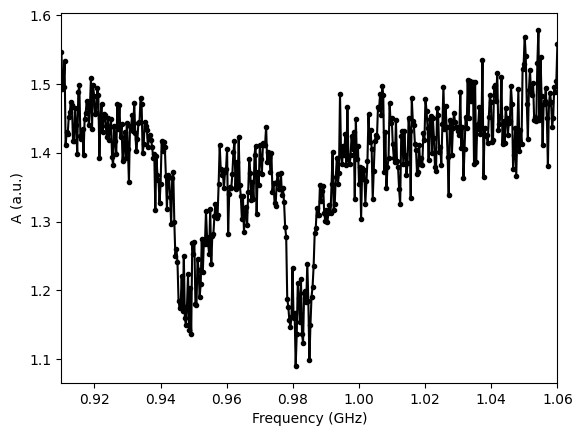

In [363]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency

# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k", ls='-')
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.margins(x=0)

# plt.axvline(0.711, linestyle = '--', alpha=0.4)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

### q0 resonator spectroscopy check

In [347]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -20e6
stop_freq = 15e6
num_points = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

readout_pulse = create_readout_pulse(q0)

In [348]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

In [349]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    q0.calibration()
)

In [350]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(q0, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(q0))

In [351]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.08.02 18:28:39.573] INFO    Starting LabOne Q Compiler run...
[2024.08.02 18:28:39.604] INFO    Schedule completed. [0.026 s]
[2024.08.02 18:28:39.676] INFO    Code generation completed for all AWGs. [0.070 s]
[2024.08.02 18:28:39.679] INFO    Completed compilation step 1 of 1. [0.101 s]
[2024.08.02 18:28:39.690] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.02 18:28:39.692] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 18:28:39.693] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.02 18:28:39.695] INFO      device_shfqc     0         23            0           1      8000  
[2024.08.02 18:28:39.696] INFO     ────────────────────────────────────────────────────────────────── 
[2024.08.02 18:28:39.698] INFO      TOTAL                      23            0                  8000  
[2024.08.02 18:28:39.701] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-08-02-18-28-39.html

In [352]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.08.02 18:28:40.230] INFO    Configuring the device setup
[2024.08.02 18:28:40.333] INFO    The device setup is configured
[2024.08.02 18:28:41.171] INFO    Starting near-time execution...
[2024.08.02 18:28:42.788] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240802T182842.json


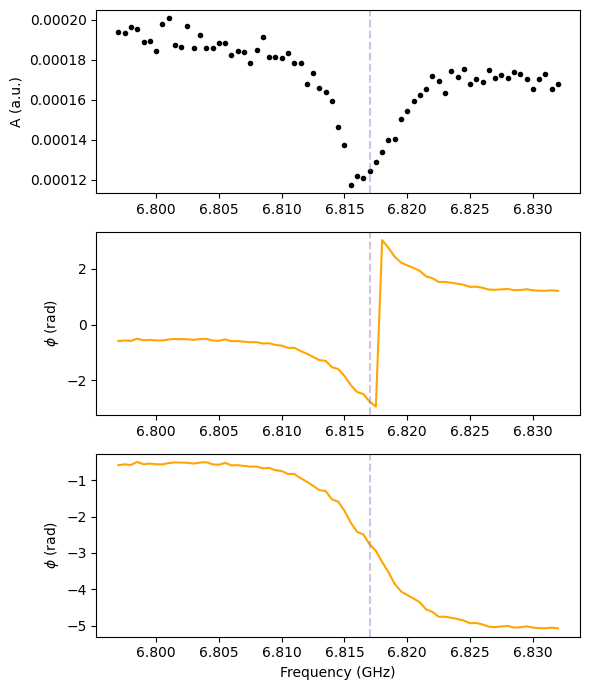

In [353]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = q0.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        q0.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + q0.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.817]
for _vl in vl:
    ax1.axvline(_vl, ls='--', 
                color='tab:purple',
                alpha=0.4,
               )
    ax2.axvline(_vl, ls='--', 
                color='tab:purple',
                alpha=0.4,
               )
    ax3.axvline(_vl, ls='--', 
                color='tab:purple',
                alpha=0.4,
               )

plt.tight_layout()

# plt.axvline(q0.parameters.readout_resonator_frequency*1e-9)

In [275]:
q0.parameters.readout_resonator_frequency = 6.817e9

#### spectroscopy

In [ ]:
target_cur = 7.986e-3
# target_cur = 7.98e-3
delta_single = target_cur - dc_q0.current()
delta_single

In [ ]:
_delta = np.dot(M_inv, np.array([delta_single, 0]).T)

In [ ]:
center_current_q0 = dc_q0.current() + _delta[0]
center_current_q1 = dc_q1.current() + _delta[1]

In [282]:
print(center_current_q0, center_current_q1)

0.007822207359938563 0.007113941488783145


In [ ]:
M = [[-1.1013, -0.1293], [-0.1286, -0.9172]]

In [ ]:
M_inv = np.linalg.inv(M)*-1

In [313]:
# (0.007822207359938563, 0.007113941488783145)
center_current_q0, center_current_q1

(0.007822207359938563, 0.007113941488783145)

In [316]:
8.45e-3 - center_current_q0

0.0006277926400614364

In [364]:
nI = 41
# dI = np.linspace(8.15, 1.3, nI)*1e-3
dI = np.linspace(8.15e-3 - center_current_q0, 8.5e-3 - center_current_q0, nI)
target_fluxes = np.vstack((dI, np.zeros(nI)))  # small tuning range on q0
dI_c = np.dot(M_inv, target_fluxes)

In [365]:
center_currents = np.vstack((np.ones(nI)*center_current_q0, np.ones(nI)*center_current_q1))

In [366]:
current_sweep = dI_c + center_currents

In [367]:
dc_q1.ramp_current(center_current_q1, 1e-6, 0)
dc_q0.ramp_current(center_current_q0, 1e-6, 0)

In [368]:
from tqdm import tqdm

In [369]:
sweep_qspec_results_q0 = []
sweep_qspec_results_q1 = []
for (I0, I1) in tqdm(current_sweep.T, file=sys.stdout):
    dc_q0.ramp_current(I0, 1e-6, 0)
    dc_q1.ramp_current(I1, 1e-6, 0)
    time.sleep(0.5)

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    
    compiled_qspec = session.compile(exp_qspec_q0)
    qspec_results_q0 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")

    compiled_qspec = session.compile(exp_qspec_q1)
    qspec_results_q1 = session.run()
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    
    qspec_res_q0 = qspec_results_q0.get_data("qb_spec")
    qspec_freq_q0 = qspec_results_q0.get_axis("qb_spec")[0] + q0.parameters.drive_lo_frequency
    sweep_qspec_results_q0.append(qspec_res_q0)
    
    
    qspec_res_q1 = qspec_results_q1.get_data("qb_spec")
    qspec_freq_q1 = qspec_results_q1.get_axis("qb_spec")[0] + q1.parameters.drive_lo_frequency
    sweep_qspec_results_q1.append(qspec_res_q1)

  0%|                                                                                           | 0/41 [00:00<?, ?it/s][2024.08.02 18:34:50.901] INFO    Starting LabOne Q Compiler run...
[2024.08.02 18:34:51.064] INFO    Schedule completed. [0.159 s]
[2024.08.02 18:34:52.134] INFO    Code generation completed for all AWGs. [1.065 s]
[2024.08.02 18:34:52.140] INFO    Completed compilation step 1 of 1. [1.233 s]
[2024.08.02 18:34:52.150] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 18:34:52.155] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.02 18:34:52.158] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.02 18:34:52.161] INFO      device_shfqc        0         10            0           1      8000  
[2024.08.02 18:34:52.165] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.08.02 18:34:52.166] INFO     ─────────────────────

In [370]:
plot_curr = (dI + center_current_q0)*1e3

Text(0.5, 1.0, 'mag')

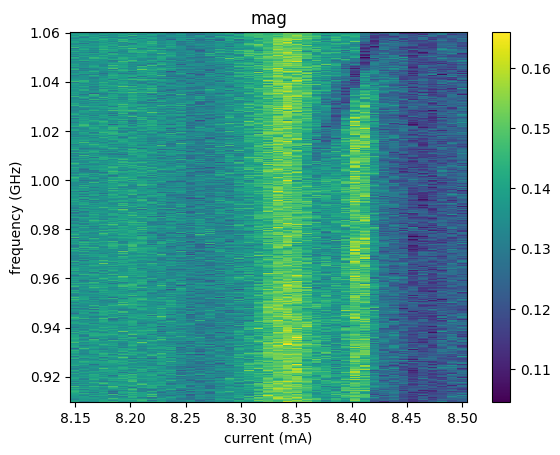

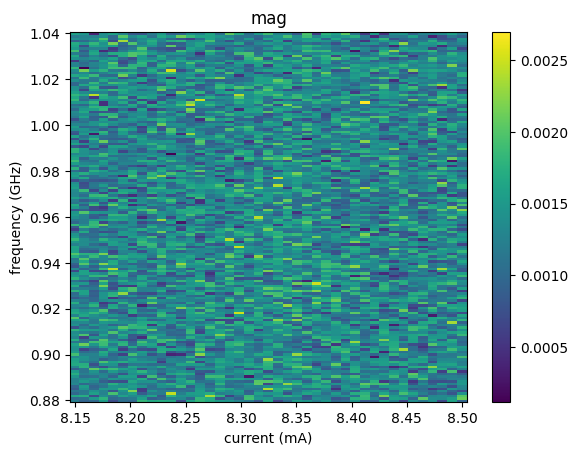

In [371]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, np.abs(sweep_qspec_results_q0).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, np.abs(sweep_qspec_results_q1).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')

In [372]:
def norm(results, thresh_low = -2, thresh_high = 2):
    angle_data = np.abs(np.unwrap(np.angle(results).T))
    norm = np.array(angle_data) - np.nanmedian(angle_data, axis=0)
    norm[(norm > thresh_high) | (norm < thresh_low)] = np.nan
    return norm

In [373]:
norm_0 = norm(sweep_qspec_results_q0)
norm_1 = norm(sweep_qspec_results_q1)

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_131596\2777410349.py:18: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


Text(0.5, 1.0, 'Q1 01 vs Q0 flux: phase')

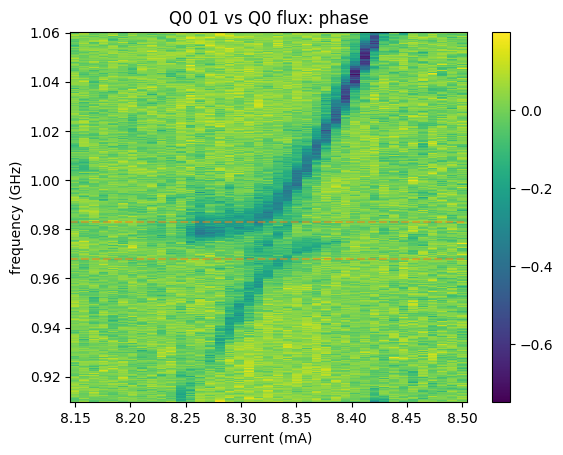

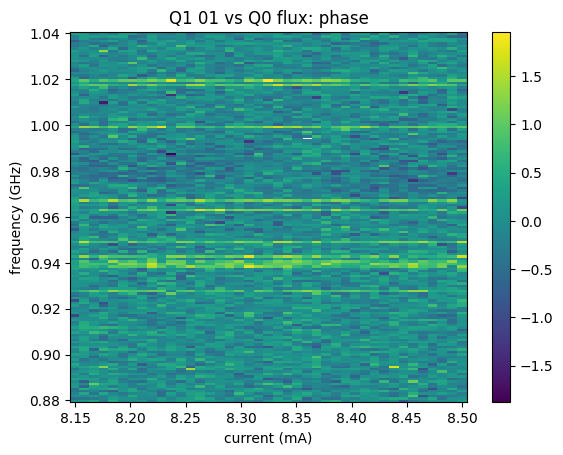

In [379]:
plt.figure()
plt.pcolor(plot_curr,qspec_freq_q0/1e9, norm_0)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q0 01 vs Q0 flux: phase')
# plt.xlim(8.2, 8.45)
# plt.ylim(0.9, 1.05)
# plt.axvline(8.2, ls='--', c='tab:orange')
# plt.axvline(8.45, ls='--', c='tab:orange')
plt.axhline(0.983, ls='--', c='tab:orange', alpha=0.5)
plt.axhline(0.968, ls='--', c='tab:orange', alpha=0.5)

plt.figure()
plt.pcolor(plot_curr,qspec_freq_q1/1e9, norm_1)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('Q1 01 vs Q0 flux: phase')

In [380]:
dc_q0.ramp_current(0, 1e-6, 0)
dc_q1.ramp_current(0, 1e-6, 0)

### 3.6 Amplitude Rabi Experiment

Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles

#### 3.6.1 Additional Experimental Parameters

Define the amplitude sweep range and qubit excitation pulse

In [860]:
dc_q0.ramp_current(7.95e-3, 1e-6, 0)

In [872]:
measure_q.parameters.resonance_frequency_ge = 0.710e9

In [909]:
measure_q.parameters.user_defined['reset_length'] = 100e-6
# measure_q.parameters.user_defined['reset_length'] = e-6

measure_q.parameters.user_defined['pulse_length'] = 2000e-9
# measure_q.parameters.user_defined['pulse_length'] = 5e-6

measure_q.parameters.user_defined['amplitude_pi'] = 0.99
measure_q.parameters.drive_range = -15
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=710000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-15,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [934]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 14

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 41
amp_min=0.01
amp_max=0.5
# amp_max=0.


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [935]:
def create_square_pulse(qubit):
    pulse = pulse_library.const(
        uid=f"square_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1, #max power to start
        # amplitude=amp, #max power to start
    )

    return pulse

In [936]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
                
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [937]:
def create_rabi_amp_sweep(qubit, amp_num, amp_min=0.1, amp_max=0.22, uid="rabi_amp"):
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

In [938]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)
# drive_pulse = create_drive_spec_pulse(measure_q)
# drive_pulse = create_square_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes, amp_min=amp_min, amp_max=amp_max), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.08.01 17:18:59.815] INFO    Starting LabOne Q Compiler run...
[2024.08.01 17:18:59.821] INFO    Schedule completed. [0.004 s]
[2024.08.01 17:18:59.857] INFO    Code generation completed for all AWGs. [0.034 s]
[2024.08.01 17:18:59.859] INFO    Completed compilation step 1 of 1. [0.041 s]
[2024.08.01 17:18:59.863] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:18:59.864] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 17:18:59.865] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:18:59.867] INFO      device_shfqc        0         11            0           1      8000  
[2024.08.01 17:18:59.868] INFO      device_shfqc_sg     0        131           41           1      8000  
[2024.08.01 17:18:59.869] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:18:59.870] INFO      TOTAL                        142 

#### 3.6.4 Show Pulse Sheet

In [939]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.08.01 17:18:59.879] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.08.01 17:18:59.882] INFO    Starting LabOne Q Compiler run...
[2024.08.01 17:18:59.891] INFO    Schedule completed. [0.007 s]
[2024.08.01 17:18:59.925] INFO    Code generation completed for all AWGs. [0.033 s]
[2024.08.01 17:18:59.927] INFO    Completed compilation step 1 of 1. [0.043 s]
[2024.08.01 17:18:59.929] INFO    Finished LabOne Q Compiler run.
[2024.08.01 17:18:59.943] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-08-01-17-18-59.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-08-01-17-18-59.html

#### 3.6.5 Plot Simulated Outputs

In [940]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [941]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.08.01 17:18:59.988] INFO    Configuring the device setup
[2024.08.01 17:19:00.092] INFO    The device setup is configured
[2024.08.01 17:19:01.107] INFO    Starting near-time execution...
[2024.08.01 17:19:01.719] INFO    Estimated RT execution time: 69.86 s.
[2024.08.01 17:20:11.867] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240801T172012.json


In [942]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

Text(0.5, 1.0, 'Resonator phase response')

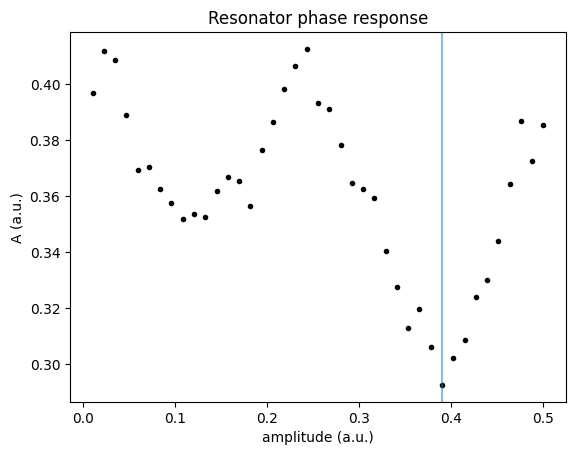

In [945]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, np.angle(rabi_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
# popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
# print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
# pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
# plt.axvline(0.5, alpha=0.5)
plt.axvline(0.39, alpha=0.5)
# pi_amp = 0.95

plt.title('Resonator phase response')

Text(0.5, 1.0, 'Resonator mag response')

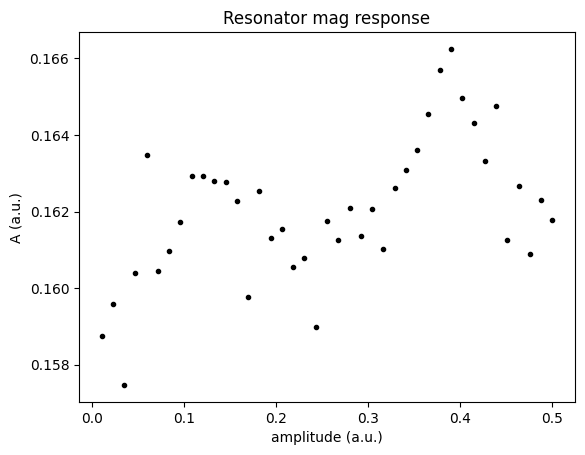

In [944]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
# popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
# print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
# pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
# plt.axvline(0.51, alpha=0.5)
# plt.axvline(0.28, alpha=0.5)
# pi_amp = 0.95

plt.title('Resonator mag response')

In [992]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6816000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=0,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.1,
│   │   │   'pulse_length': 4e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

In [946]:
# rabi_amplitude = pi_amp
measure_q.parameters.user_defined['amplitude_pi'] = 0.39
# measure_q.parameters.user_defined['amplitude_pi/2'] = 0.51

# T1

#### 3.7.1 Experiment Parameters

In [947]:
measure_q?

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=710000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-15,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.39,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

In [948]:
measure_q.parameters.user_defined['reset_length'] = 150e-6
# measure_q.parameters.user_defined['pulse_length'] = 20e-6
# measure_q.parameters.drive_range = 10

In [949]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 25
start_delay = 0e-6
stop_delay = 200e-6


#### 3.7.2 Experiment Definition

In [950]:
# function that returns a T1 experiment


def T1(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_T1 = Experiment(
        uid="T1 Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define T1 experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_T1.acquire_loop_rt(
        uid="T1_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        
        # inner loop - real time sweep of T1 time delays
        with exp_T1.sweep(
            uid="T1_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - delay is swept
            with exp_T1.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_T1.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_T1.delay(signal="drive", time=time_sweep)
            # readout pulse and data acquisition
            with exp_T1.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_T1.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_T1.acquire(
                    signal="acquire",
                    handle="T1",
                    kernel=readout_pulse,
                )
            with exp_T1.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_T1.reserve(signal="measure")
    return exp_T1

#### 3.7.3 Create Experiment and Signal Map

In [951]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_T1_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

T1_exp = T1(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

T1_exp.set_signal_map(signal_map_default(measure_q))

compiled_T1 = session.compile(T1_exp)

[2024.08.01 17:22:30.136] INFO    Starting LabOne Q Compiler run...
[2024.08.01 17:22:30.141] INFO    Schedule completed. [0.003 s]
[2024.08.01 17:22:30.181] INFO    Code generation completed for all AWGs. [0.038 s]
[2024.08.01 17:22:30.184] INFO    Completed compilation step 1 of 1. [0.045 s]
[2024.08.01 17:22:30.189] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:22:30.191] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 17:22:30.193] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:22:30.195] INFO      device_shfqc        0        190            0           1      8000  
[2024.08.01 17:22:30.197] INFO      device_shfqc_sg     0        139            3           3     24064  
[2024.08.01 17:22:30.198] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 17:22:30.200] INFO      TOTAL                        329 

#### 3.7.4 Show Pulse Sheet

In [952]:
show_pulse_sheet("Pulse_Sheets/T1", compiled_T1)

[2024.08.01 17:22:30.213] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.08.01 17:22:30.216] INFO    Starting LabOne Q Compiler run...
[2024.08.01 17:22:30.228] INFO    Schedule completed. [0.009 s]
[2024.08.01 17:22:30.262] INFO    Code generation completed for all AWGs. [0.033 s]
[2024.08.01 17:22:30.264] INFO    Completed compilation step 1 of 1. [0.045 s]
[2024.08.01 17:22:30.265] INFO    Finished LabOne Q Compiler run.
[2024.08.01 17:22:30.279] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-08-01-17-22-30.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-08-01-17-22-30.html

#### 3.7.5 Plot Simulated Outputs

In [953]:
# plot_simulation(compiled_T1, 100e-6, 150e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [954]:
# run the compiled experiemnt
T1_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/T1_results_{timestamp}.json")
print(f"File saved as Results_Needed/T1_results_{timestamp}.json")

[2024.08.01 17:23:01.630] INFO    Configuring the device setup
[2024.08.01 17:23:01.735] INFO    The device setup is configured
[2024.08.01 17:23:02.584] INFO    Starting near-time execution...
[2024.08.01 17:23:03.110] INFO    Estimated RT execution time: 52.02 s.
[2024.08.01 17:23:55.390] INFO    Finished near-time execution.
File saved as Results_Needed/T1_results_20240801T172355.json


In [955]:
# get measurement data returned by the instruments
T1_res = T1_results.get_data("T1")

# define time axis from qubit parameters
T1_delay = T1_results.get_axis("T1")[0]

if emulate:
    # create dummy data if running in emulation mode
    T1_res = exponential_decay(
        T1_delay, 2e5, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(T1_delay))

Text(0.5, 0, 'delay (us)')

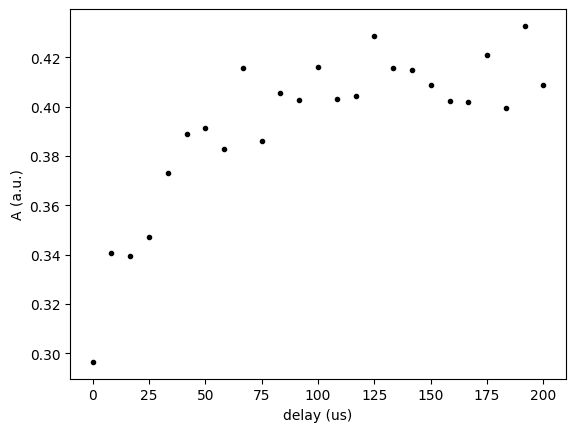

In [956]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay*1e6, np.angle(T1_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

Text(0.5, 0, 'delay (us)')

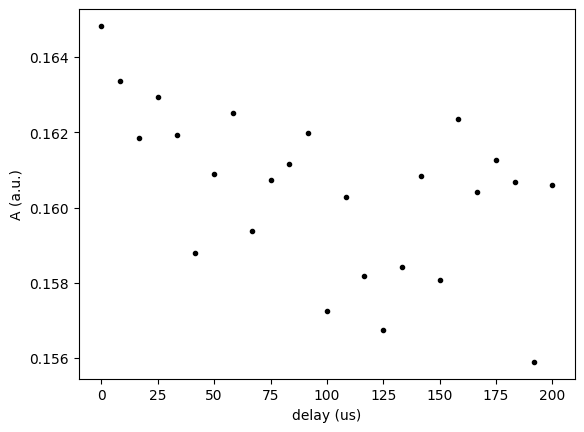

In [957]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay*1e6, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

Fitted parameters: [ 2.94601497e+04  4.13699360e-01 -1.12299591e-01]
T1 time 33.944158764551354 us


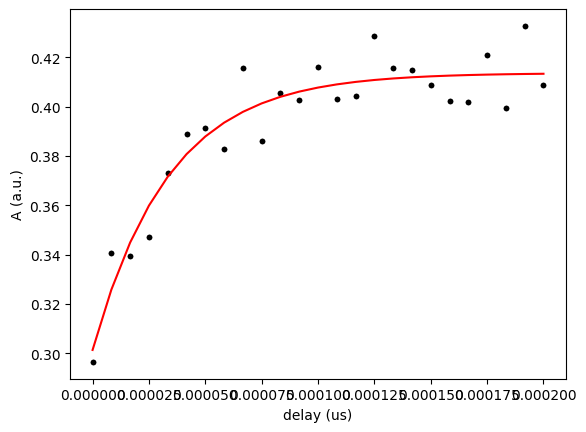

In [958]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay, np.angle(T1_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

# increase number of plot points for smooth plotting of fit results
#delay_plot = np.linspace(T1_delay[0], T1_delay[-1], 5 * len(T1_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = exponential_decay.fit(
   T1_delay,
   np.angle(T1_res),
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 
# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

In [682]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=711000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-20,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.32,
│   │   │   'pulse_length': 1.5e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0003
│   │   }
│   )
)

### 3.7 Ramsey Experiment
The Ramsey experiment is different from the experiments above as the length of the drive section changes. Using a right-aligned sweep section and the automatic repetition time makes sure that the experiment is run as efficiently as possible on the Zurich Instruments hardware.

#### 3.7.1 Experiment Parameters

In [699]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

# define delay sweep
n_steps = 41
start_delay = 0e-6
stop_delay = 20e-6


#### 3.7.2 Experiment Definition

In [700]:
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']/2,
    )

In [701]:
# function that returns a Ramsey experiment


def ramsey(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_ramsey = Experiment(
        uid="Ramsey Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - pulse delay is swept
            with exp_ramsey.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_ramsey.delay(signal="drive", time=time_sweep)
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_ramsey.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_ramsey.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey.acquire(
                    signal="acquire",
                    handle="ramsey",
                    kernel=readout_pulse,
                )
            with exp_ramsey.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_ramsey.reserve(signal="measure")
    return exp_ramsey

In [702]:
# #measure_q.parameters.user_defined['reset_length'] = 1e-3
# measure_q.parameters.resonance_frequency_ge = measure_q.parameters.resonance_frequency_ge
# print(measure_q)

#### 3.7.3 Create Experiment and Signal Map

In [703]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_ramsey_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

ramsey_exp = ramsey(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

ramsey_exp.set_signal_map(signal_map_default(measure_q))

compiled_ramsey = session.compile(ramsey_exp)

[2024.08.01 16:12:46.821] INFO    Starting LabOne Q Compiler run...
[2024.08.01 16:12:46.828] INFO    Schedule completed. [0.005 s]
[2024.08.01 16:12:46.871] INFO    Code generation completed for all AWGs. [0.041 s]
[2024.08.01 16:12:46.874] INFO    Completed compilation step 1 of 1. [0.051 s]
[2024.08.01 16:12:46.878] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 16:12:46.880] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 16:12:46.881] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 16:12:46.883] INFO      device_shfqc        0        251            0           1      8000  
[2024.08.01 16:12:46.884] INFO      device_shfqc_sg     0        299            3           3     24032  
[2024.08.01 16:12:46.886] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 16:12:46.888] INFO      TOTAL                        550 

#### 3.7.4 Show Pulse Sheet

In [704]:
show_pulse_sheet("Pulse_Sheets/Ramsey", compiled_ramsey)

[2024.08.01 16:12:46.903] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.08.01 16:12:46.908] INFO    Starting LabOne Q Compiler run...
[2024.08.01 16:12:46.920] INFO    Schedule completed. [0.008 s]
[2024.08.01 16:12:46.960] INFO    Code generation completed for all AWGs. [0.037 s]
[2024.08.01 16:12:46.964] INFO    Completed compilation step 1 of 1. [0.052 s]
[2024.08.01 16:12:46.967] INFO    Finished LabOne Q Compiler run.
[2024.08.01 16:12:46.983] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Ramsey_2024-08-01-16-12-46.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Ramsey_2024-08-01-16-12-46.html

#### 3.7.5 Plot Simulated Outputs

In [705]:
# plot_simulation(compiled_ramsey, 50e-6, 100e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [706]:
# run the compiled experiemnt
ramsey_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/ramsey_results_{timestamp}_.json")
print(f"File saved as Results/ramsey_results_{timestamp}_.json")

[2024.08.01 16:12:47.087] INFO    Configuring the device setup
[2024.08.01 16:12:47.199] INFO    The device setup is configured
[2024.08.01 16:12:48.239] INFO    Starting near-time execution...
[2024.08.01 16:12:48.867] INFO    Estimated RT execution time: 52.90 s.
[2024.08.01 16:13:42.024] INFO    Finished near-time execution.
File saved as Results/ramsey_results_20240801T161342_.json


In [707]:
# get measurement data returned by the instruments
ramsey_res = ramsey_results.get_data("ramsey")

# define time axis from qubit parameters
ramsey_delay = ramsey_results.get_axis("ramsey")[0]

if emulate:
    # create dummy data if running in emulation mode
    ramsey_res = oscillatory_decay(
        ramsey_delay, 1e6, 0, 1 / 10e-6, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(ramsey_delay))

Fitted parameters: [3.47631100e+07 1.73016504e+01 1.19969055e+05 1.05250166e-01
 3.24325385e-01]


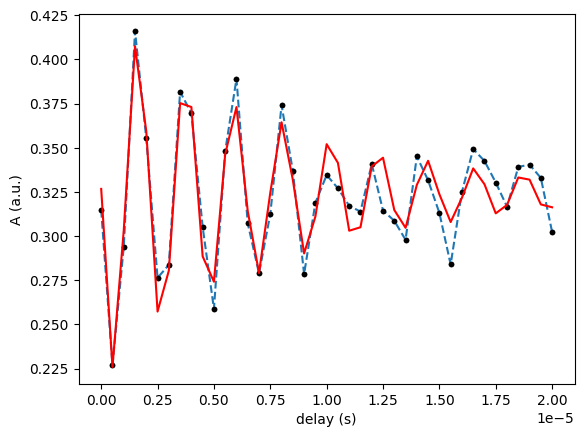

In [708]:
# plot measurement results
fig = plt.figure()
plt.plot(ramsey_delay, np.angle(ramsey_res), ".k")
plt.plot(ramsey_delay, np.angle(ramsey_res), linestyle ='--')

plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(ramsey_delay[0], ramsey_delay[-1], 5 * len(ramsey_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    ramsey_delay,
    np.angle(ramsey_res),
    10/0.5e-6,
    0,
    1 / 4e-6,
    0.002,
    0.0008,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [710]:
print(f'T2r = {1e6/popt[2]} us')

T2r = 8.335482871561986 us


In [698]:
# measure_q.parameters.resonance_frequency_ge = measure_q.parameters.resonance_frequency_ge + 0.5e6

In [1939]:
measure_q.parameters.resonance_frequency_ge

1160700000.0

In [1937]:
measure_q.parameters.resonance_frequency_ge = 1.1607e9

In [1938]:
device_setup.set_calibration(
    measure_q.calibration()
)

### 3.9 echo Experiment
Adding a Y180 pulse in middle of Ramsey

In [749]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=711000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-20,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [811]:
measure_q.parameters.user_defined['reset_length'] = 300e-6

In [812]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 14

# define delay sweep
n_steps = 41
start_delay = 0e-6
stop_delay = 80e-6


#### 3.9.2 Experiment Definition

In [813]:
# function that returns an Echo experiment


def echo(x90_pulse, y180_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_echo = Experiment(
        uid="Echo Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Echo experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_echo.acquire_loop_rt(
        uid="echo_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of echo time delays
        with exp_echo.sweep(
            uid="echo_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse
            with exp_echo.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=y180_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_echo.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_echo.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_echo.acquire(
                    signal="acquire",
                    handle="echo",
                    kernel=readout_pulse,
                )
            with exp_echo.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_echo.reserve(signal="measure")
    return exp_echo

In [814]:
# measure_q.parameters.resonance_frequency_ge = 4.5509e9+190e3
# measure_q.parameters.user_defined['reset_length'] = 5e-3
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=711000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1000000000.0,
│   │   readout_resonator_frequency=6819000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-20,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0003
│   │   }
│   )
)

#### 3.9.3 Create Experiment and Signal Map

In [815]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
x90_pulse = create_pi_2_pulse(measure_q)
y180_pulse = create_pi_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

echo_exp = echo(
    x90_pulse=x90_pulse, y180_pulse=y180_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

echo_exp.set_signal_map(signal_map_default(measure_q))

compiled_echo = session.compile(echo_exp)

[2024.08.01 16:42:51.226] INFO    Starting LabOne Q Compiler run...
[2024.08.01 16:42:51.236] INFO    Schedule completed. [0.006 s]
[2024.08.01 16:42:51.285] INFO    Code generation completed for all AWGs. [0.046 s]
[2024.08.01 16:42:51.287] INFO    Completed compilation step 1 of 1. [0.056 s]
[2024.08.01 16:42:51.290] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 16:42:51.291] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 16:42:51.293] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 16:42:51.295] INFO      device_shfqc        0        260            0           1      8000  
[2024.08.01 16:42:51.296] INFO      device_shfqc_sg     0        378            2           2      8000  
[2024.08.01 16:42:51.298] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 16:42:51.300] INFO      TOTAL                        638 

#### 3.9.4 Show Pulse Sheet

In [816]:
show_pulse_sheet("Pulse_Sheets/echo", compiled_echo)

[2024.08.01 16:42:51.311] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.08.01 16:42:51.313] INFO    Starting LabOne Q Compiler run...
[2024.08.01 16:42:51.324] INFO    Schedule completed. [0.008 s]
[2024.08.01 16:42:51.370] INFO    Code generation completed for all AWGs. [0.044 s]
[2024.08.01 16:42:51.374] INFO    Completed compilation step 1 of 1. [0.058 s]
[2024.08.01 16:42:51.378] INFO    Finished LabOne Q Compiler run.
[2024.08.01 16:42:51.397] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\echo_2024-08-01-16-42-51.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\echo_2024-08-01-16-42-51.html

#### 3.9.5 Plot Simulated Outputs

In [817]:
# plot_simulation(compiled_echo, 4000e-6, 4050e-6, plot_width=10)

#### 3.9.6 Run, Save, and Plot Results

In [818]:
# run the compiled experiemnt
echo_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/echo_results_{timestamp}.json")
print(f"File saved as Results/echo_results_{timestamp}.json")

[2024.08.01 16:42:51.493] INFO    Configuring the device setup
[2024.08.01 16:42:51.608] INFO    The device setup is configured
[2024.08.01 16:42:52.597] INFO    Starting near-time execution...
[2024.08.01 16:42:53.271] INFO    Estimated RT execution time: 231.75 s.
[2024.08.01 16:46:45.268] INFO    Finished near-time execution.
File saved as Results/echo_results_20240801T164645.json


In [819]:
# get measurement data returned by the instruments
echo_res = echo_results.get_data("echo")

# define time axis from qubit parameters
echo_delay = echo_results.get_axis("echo")[0]


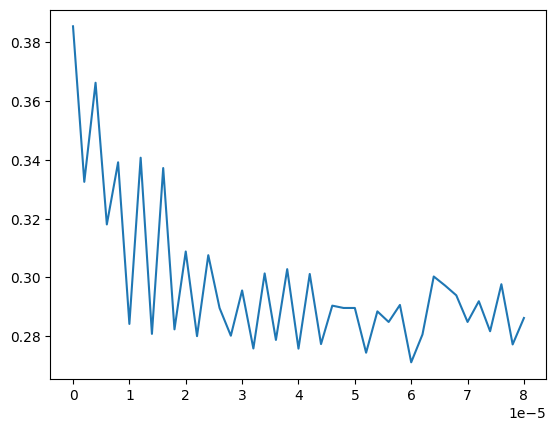

In [820]:
plt.plot(echo_delay, np.angle(echo_res))

Fitted parameters: [1.10201121e+05 2.86980842e-01 8.80823540e-02]
T2e time 9.074317861675151 us


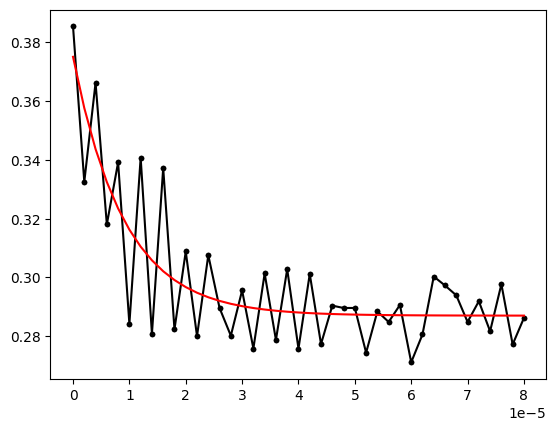

In [821]:
plt.plot(echo_delay, np.angle(echo_res), ls='-', marker='.', color='k')
popt, pcov = exponential_decay.fit(
   echo_delay,
   np.angle(echo_res),
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

Fitted parameters: [ 3.57882269e+05  1.65972838e-01 -5.79709193e-03]
T2e time 2.7942149898262243 us


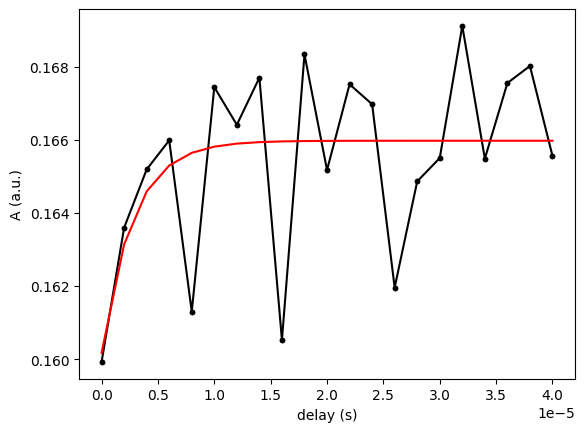

In [806]:
# plot measurement results (XXX) 5 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel(r"delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

popt, pcov = exponential_decay.fit(
   echo_delay,
   echo_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

In [ ]:
popt, pcov = exponential_decay.fit(
   echo_delay,
   np.angle(echo_res),
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 